In [1]:
import pandas as pd
import zstandard as zstd
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
CALENDAR_DATA_V2_PATH = "../data/raw/v2/calendar.csv.zst"
LISTINGS_DATA_V2_PATH = '../data/raw/v2/listings.csv.zst'
REVIEWS_DATA_V2_PATH = '../data/raw/v2/reviews.csv.zst'
SESSIONS_DATA_V2_PATH = '../data/raw/v2/sessions.csv.zst'
USERS_DATA_V2_PATH = '../data/raw/v2/users.csv.zst'



In [3]:
def read_large_csv_zst(file_path, chunksize=100000, **kwargs):
    dctx = zstd.ZstdDecompressor()
    with open(file_path, 'rb') as fh:
        with dctx.stream_reader(fh) as reader:
            text_stream = io.TextIOWrapper(reader, encoding='utf-8')
            chunk_iter = pd.read_csv(text_stream, chunksize=chunksize, **kwargs)
            for chunk in chunk_iter:
                yield chunk

def create_dataframe_from_csv_zst(filepath: str) -> pd.DataFrame:
    dctx = zstd.ZstdDecompressor()
    with open(filepath, 'rb') as compressed:
        with dctx.stream_reader(compressed) as reader:
            decompressed = io.TextIOWrapper(reader, encoding='utf-8')
            df = pd.read_csv(
                decompressed,
                low_memory=True
            )
    return df

In [5]:
callendar_df = create_dataframe_from_csv_zst(CALENDAR_DATA_V2_PATH)
listings_df = create_dataframe_from_csv_zst(LISTINGS_DATA_V2_PATH)
reviews_df = create_dataframe_from_csv_zst(REVIEWS_DATA_V2_PATH)
users_df = create_dataframe_from_csv_zst(USERS_DATA_V2_PATH)

/tmp/ipykernel_373/762385955.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(
/tmp/ipykernel_373/762385955.py:15: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


### Missing Values

In [4]:
# checking missing values in the dataframes
def check_dataframe_missing_values(df: pd.DataFrame) -> None:
    total_values = len(df)

    df_columns = df.columns

    for col in df_columns:
        missing_values = df[col].isnull().sum()
        missing_percentage = (missing_values / total_values) * 100
        print(f"Column: {col}, Missing Values: {missing_values}, Missing Percentage: {missing_percentage:.2f}%")


def missing_values_visualization(df: pd.DataFrame, title: str, figsize: tuple = (12,6)) -> None:
    plt.figure(figsize=(12, 6))

    counts = []
    for col in df.columns:
        counts.append({'column': col, 'status': 'Existing', 'count': df[col].notnull().sum()})
        counts.append({'column': col, 'status': 'Missing', 'count': df[col].isna().sum()})
    counts_df = pd.DataFrame(counts)

    plt.figure(figsize=figsize)
    sns.barplot(data=counts_df, x='column', y='count', hue='status', edgecolor='black')
    plt.title(title)
    plt.xticks(rotation=90)

    plt.show()


Column: listing_id, Missing Values: 0, Missing Percentage: 0.00%
Column: date, Missing Values: 0, Missing Percentage: 0.00%
Column: available, Missing Values: 0, Missing Percentage: 0.00%
Column: price, Missing Values: 0, Missing Percentage: 0.00%
Column: adjusted_price, Missing Values: 14580728, Missing Percentage: 100.00%
Column: minimum_nights, Missing Values: 6899, Missing Percentage: 0.05%
Column: maximum_nights, Missing Values: 6899, Missing Percentage: 0.05%


<Figure size 1200x600 with 0 Axes>

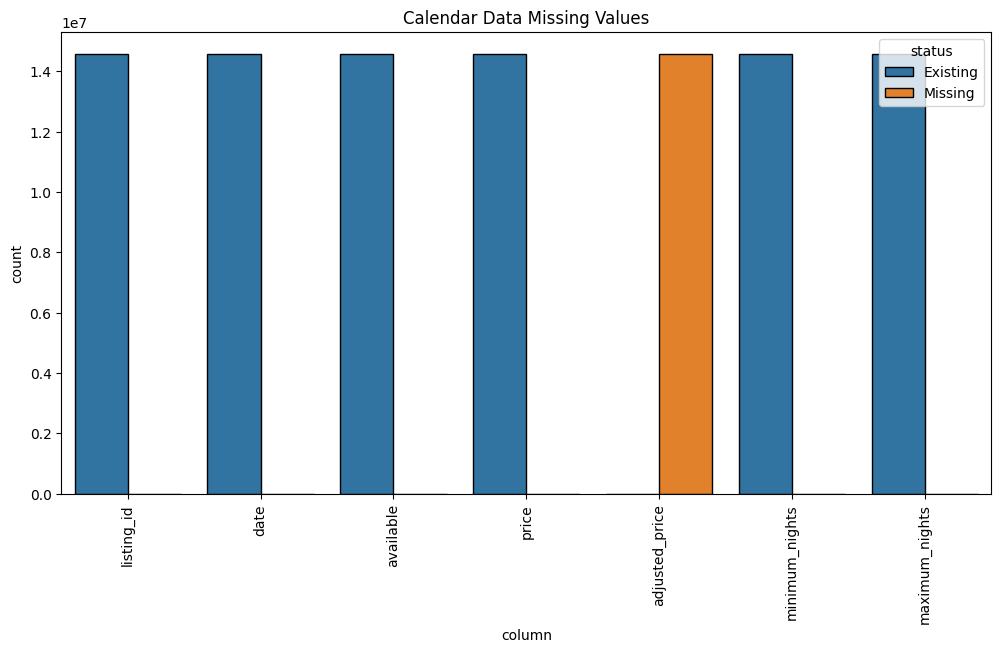

In [6]:
check_dataframe_missing_values(callendar_df)
missing_values_visualization(callendar_df, "Calendar Data Missing Values")

Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: listing_url, Missing Values: 0, Missing Percentage: 0.00%
Column: scrape_id, Missing Values: 0, Missing Percentage: 0.00%
Column: last_scraped, Missing Values: 0, Missing Percentage: 0.00%
Column: source, Missing Values: 0, Missing Percentage: 0.00%
Column: name, Missing Values: 0, Missing Percentage: 0.00%
Column: description, Missing Values: 1207, Missing Percentage: 3.02%
Column: neighborhood_overview, Missing Values: 21014, Missing Percentage: 52.63%
Column: picture_url, Missing Values: 1, Missing Percentage: 0.00%
Column: host_id, Missing Values: 0, Missing Percentage: 0.00%
Column: host_url, Missing Values: 0, Missing Percentage: 0.00%
Column: host_name, Missing Values: 19, Missing Percentage: 0.05%
Column: host_since, Missing Values: 19, Missing Percentage: 0.05%
Column: host_location, Missing Values: 12112, Missing Percentage: 30.33%
Column: host_about, Missing Values: 19822, Missing Percentage: 49.64%
Column: hos

<Figure size 1200x600 with 0 Axes>

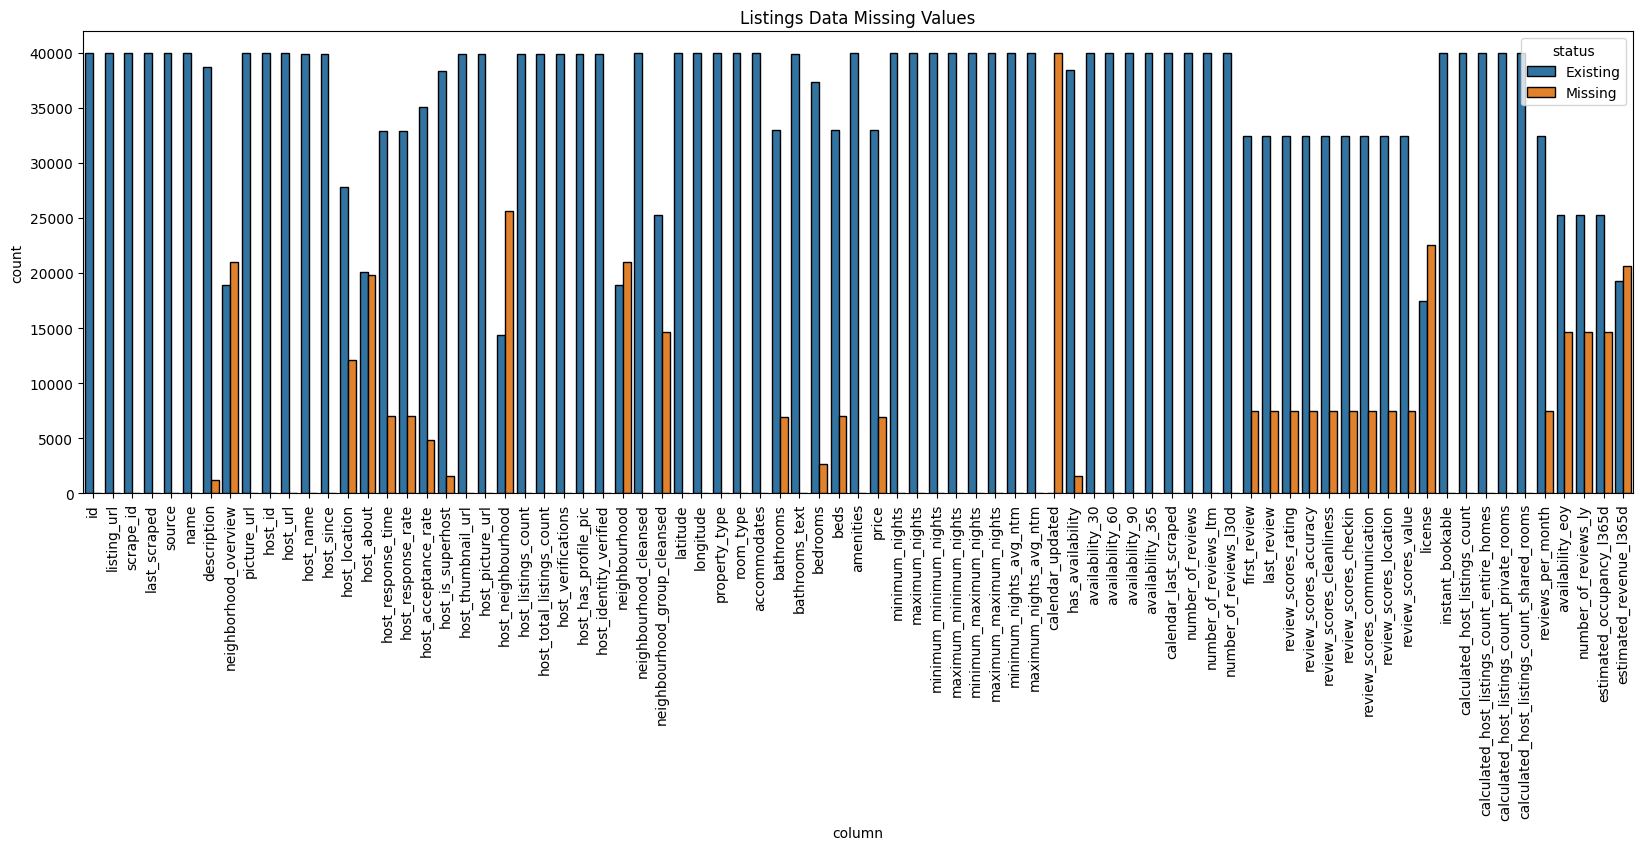

In [8]:
check_dataframe_missing_values(listings_df)
missing_values_visualization(listings_df, "Listings Data Missing Values", figsize=(20, 6))


Column: listing_id, Missing Values: 0, Missing Percentage: 0.00%
Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: date, Missing Values: 0, Missing Percentage: 0.00%
Column: reviewer_id, Missing Values: 0, Missing Percentage: 0.00%
Column: reviewer_name, Missing Values: 3, Missing Percentage: 0.00%
Column: comments, Missing Values: 156, Missing Percentage: 0.01%


<Figure size 1200x600 with 0 Axes>

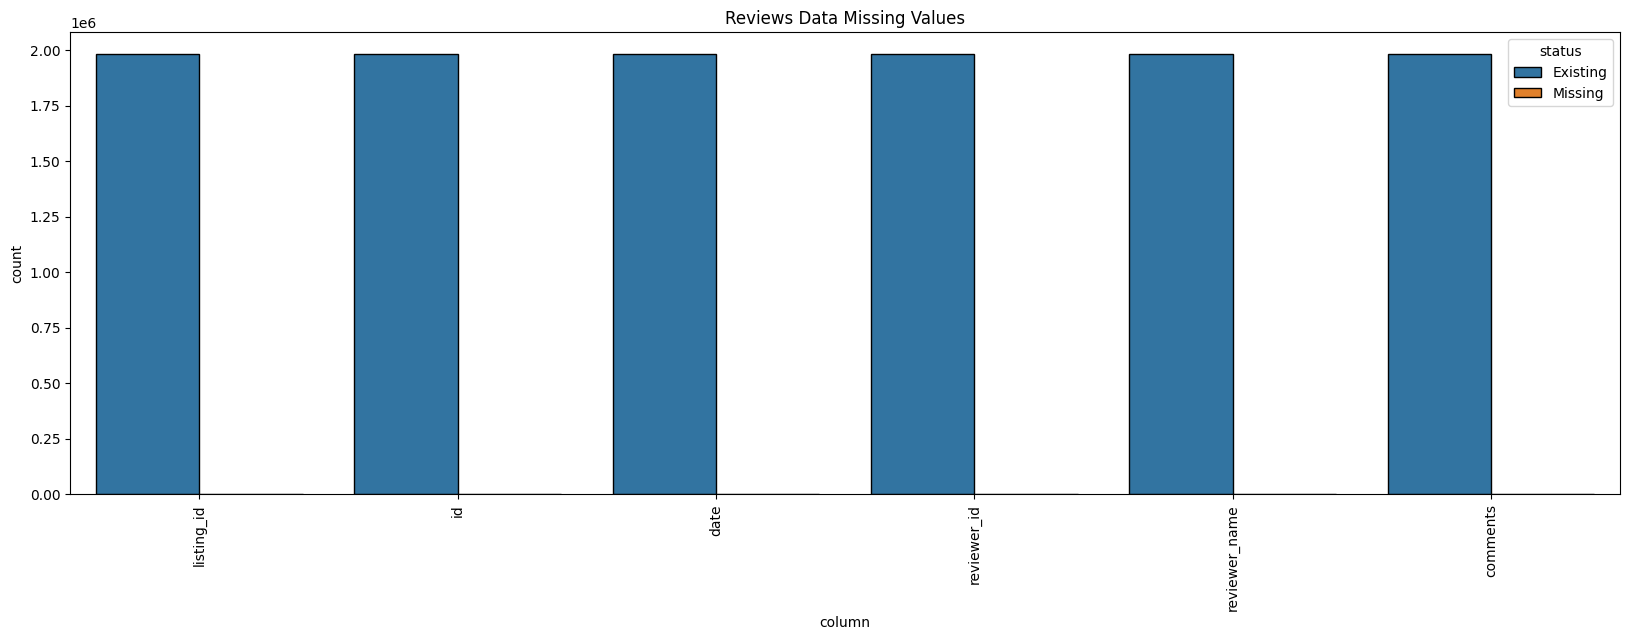

In [9]:
check_dataframe_missing_values(reviews_df)
missing_values_visualization(reviews_df, "Reviews Data Missing Values", figsize=(20, 6))

Column: id, Missing Values: 0, Missing Percentage: 0.00%
Column: name, Missing Values: 0, Missing Percentage: 0.00%
Column: surname, Missing Values: 0, Missing Percentage: 0.00%
Column: city, Missing Values: 0, Missing Percentage: 0.00%
Column: street, Missing Values: 0, Missing Percentage: 0.00%
Column: street_number, Missing Values: 0, Missing Percentage: 0.00%
Column: postal_code, Missing Values: 0, Missing Percentage: 0.00%


<Figure size 1200x600 with 0 Axes>

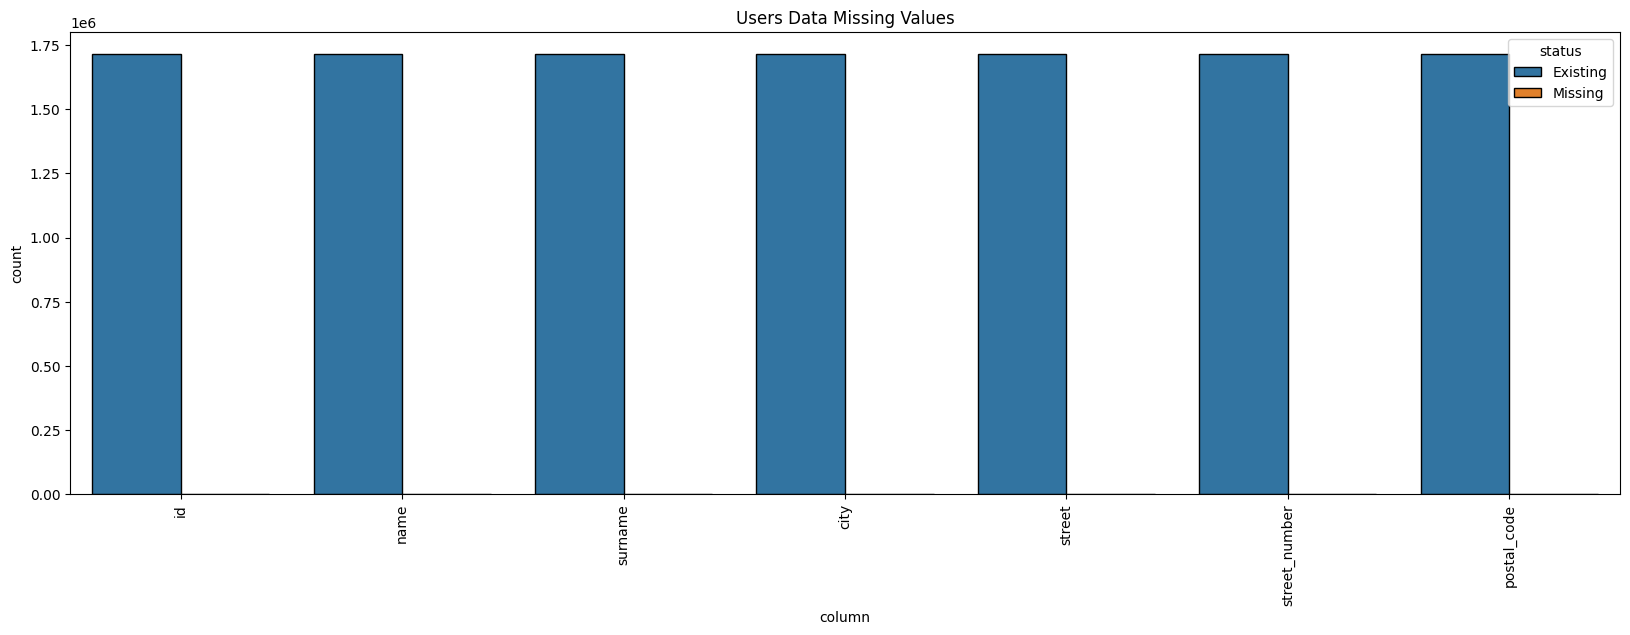

In [10]:
check_dataframe_missing_values(users_df)
missing_values_visualization(users_df, "Users Data Missing Values", figsize=(20, 6))

### Missing values in sessions

In [23]:
# getting columns names
for chunk in read_large_csv_zst(SESSIONS_DATA_V2_PATH, nrows=1):
    columns = chunk.columns
    break


In [ ]:
columns_list = list(columns)

In [ ]:
def calculate_missing_values_in_sessions_data(file_path: str) -> dict:
    # initialize dictionary to store aggregated counts for each column
    missing_stats = {col: {'total_values': 0, 'missing_values': 0} for col in columns_list}

    # iterate over chunks and update counts
    for chunk in read_large_csv_zst(file_path):
        for col in chunk.columns:
            missing_stats[col]['total_values'] += len(chunk[col])
            missing_stats[col]['missing_values'] += chunk[col].isnull().sum()

    # print results for each column
    for col, stats in missing_stats.items():
        total = stats['total_values']
        missing = stats['missing_values']
        perc = (missing / total * 100) if total > 0 else 0
        print(f"Column: {col}, Total: {total}, Missing: {missing}, Missing Percentage: {perc:.2f}%")

    return missing_stats

In [33]:
missing_sessions_stats = calculate_missing_values_in_sessions_data(SESSIONS_DATA_V2_PATH)

Column: action, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: user_id, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: timestamp, Total: 26846024, Missing: 0, Missing Percentage: 0.00%
Column: listing_id, Total: 26846024, Missing: 1982822, Missing Percentage: 7.39%
Column: booking_date, Total: 26846024, Missing: 24863202, Missing Percentage: 92.61%
Column: booking_duration, Total: 26846024, Missing: 24863202, Missing Percentage: 92.61%
Column: booking_id, Total: 26846024, Missing: 24783884, Missing Percentage: 92.32%


In [ ]:
sessions_chunk = pd.read_csv(SESSIONS_DATA_V2_PATH, nrows=100000)
sessions_chunk.head(5)

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id
0,browse_listings,3415451,2012-08-10T12:43:14.448407,NaN,NaN,NaN,NaN
1,view_listing,3415451,2012-08-10T12:46:04.448407,4.319166e+07,NaN,NaN,NaN
2,view_listing,3415451,2012-08-10T12:55:47.448407,3.656159e+07,NaN,NaN,NaN
3,view_listing,3415451,2012-08-10T13:55:25.448407,6.729309e+17,NaN,NaN,NaN
4,view_listing,3415451,2012-08-10T14:32:03.448407,1.183135e+18,NaN,NaN,NaN


### Dataframe zawierający tylko zabookwane wyjazdy

In [36]:
booked_sessions_df = pd.DataFrame()

for chunk in read_large_csv_zst(SESSIONS_DATA_V2_PATH):
    booked_sessions_df = pd.concat([booked_sessions_df, chunk[chunk['booking_date'].notna()]], ignore_index=True)

booked_sessions_df.head()

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id
0,book_listing,3415451,2012-08-10T14:32:03.448407,27262.0,2012-08-22,2012-08-26,37092524-b4d4-46d0-9ae5-d449f3d39415
1,book_listing,30220642,2014-06-02T11:50:12.387760,27262.0,2015-01-25,2015-01-30,b4760b9e-b1f5-47a8-9fd5-842ef0cab1d5
2,book_listing,35701367,2015-06-03T05:52:56.241550,27262.0,2015-06-09,2015-06-14,ce3be8c6-976b-4ebf-a202-51fbbf359cb7
3,book_listing,47390335,2015-03-19T16:13:01.823658,27262.0,2015-10-07,2015-10-13,f74f81c1-7ea5-4b72-abe2-9b3d98b59570
4,book_listing,31391271,2015-07-22T18:29:40.960157,27262.0,2015-09-06,2015-09-12,f9de1076-3939-4d34-a690-dc442c11ecb8


In [60]:
booked_sessions_df['duration'] = pd.to_datetime(booked_sessions_df['booking_duration']) - pd.to_datetime(booked_sessions_df['booking_date'])
booked_sessions_df['duration'] = booked_sessions_df['duration'].dt.total_seconds() / 3600  / 24 # convert to whole days
booked_sessions_df['duration'] = booked_sessions_df['duration'].astype(int)

In [61]:
booked_sessions_df.head(5)

,action,user_id,timestamp,listing_id,booking_date,booking_duration,booking_id,duration,booking_year
0,book_listing,3415451,2012-08-10T14:32:03.448407,27262.0,2012-08-22,2012-08-26,37092524-b4d4-46d0-9ae5-d449f3d39415,4,2012
1,book_listing,30220642,2014-06-02T11:50:12.387760,27262.0,2015-01-25,2015-01-30,b4760b9e-b1f5-47a8-9fd5-842ef0cab1d5,5,2015
2,book_listing,35701367,2015-06-03T05:52:56.241550,27262.0,2015-06-09,2015-06-14,ce3be8c6-976b-4ebf-a202-51fbbf359cb7,5,2015
3,book_listing,47390335,2015-03-19T16:13:01.823658,27262.0,2015-10-07,2015-10-13,f74f81c1-7ea5-4b72-abe2-9b3d98b59570,6,2015
4,book_listing,31391271,2015-07-22T18:29:40.960157,27262.0,2015-09-06,2015-09-12,f9de1076-3939-4d34-a690-dc442c11ecb8,6,2015


In [57]:
def calculate_bookings_with_k_duration(booked_sessions_df: pd.DataFrame, k: int) -> pd.DataFrame:
    return booked_sessions_df[booked_sessions_df['duration'] == k]

for k in sorted(booked_sessions_df['duration'].unique()):
    bookings_with_k_duration = calculate_bookings_with_k_duration(booked_sessions_df, k)
    print(f"Bookings with {k} days duration: {len(bookings_with_k_duration)}")

Bookings with 1 days duration: 181194
Bookings with 2 days duration: 229413
Bookings with 3 days duration: 230280
Bookings with 4 days duration: 228997
Bookings with 5 days duration: 235164
Bookings with 6 days duration: 197607
Bookings with 7 days duration: 168420
Bookings with 8 days duration: 149599
Bookings with 9 days duration: 147370
Bookings with 10 days duration: 131596
Bookings with 11 days duration: 66400
Bookings with 12 days duration: 15305
Bookings with 13 days duration: 1426
Bookings with 14 days duration: 51


In [40]:
unique_listings = booked_sessions_df['listing_id'].unique()
unique_listings_count = len(unique_listings)
print(f"Unique Listings Count: {unique_listings_count}")

Unique Listings Count: 32420


In [63]:
callendar_df['year'] = pd.to_datetime(callendar_df['date']).dt.year
unique_years = callendar_df['year'].unique()
print(f"Unique Years in Calendar Data: {unique_years}")


Unique Years in Calendar Data: [2024 2025 2026]


### Statystyki wynajęć danego listingu
- średnia długość
- minimalne wynajęcia
- maksymalne wynajęcia

In [51]:
listings_statistics = booked_sessions_df.groupby('listing_id').agg(
    total_bookings=('booking_date', 'count'),
    total_duration=('duration', 'sum'),
    avg_duration=('duration', 'mean'),
    min_duration=('duration', 'min'),
    max_duration=('duration', 'max')
).reset_index()


duration_counts = booked_sessions_df.groupby(['listing_id', 'duration']).size().unstack(fill_value=0)


for k in range(1, 15):
    if k not in duration_counts.columns:
        duration_counts[k] = 0

duration_counts = duration_counts[[k for k in range(1, 15)]]

listings_statistics = listings_statistics.merge(duration_counts, how='left', left_on='listing_id', right_index=True)
listings_statistics.fillna(0, inplace=True)

listings_statistics.head()

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,21853.0,33,48,1.454545,1,4,21,10,1,1,0,0,0,0,0,0,0,0,0,0
1,27262.0,29,144,4.965517,2,7,0,1,2,6,9,10,1,0,0,0,0,0,0,0
2,30320.0,172,360,2.093023,1,4,43,76,47,6,0,0,0,0,0,0,0,0,0,0
3,30959.0,8,12,1.500000,1,3,5,2,1,0,0,0,0,0,0,0,0,0,0,0
4,33945.0,78,540,6.923077,3,10,0,0,2,1,5,17,29,18,4,2,0,0,0,0


### Macierz korelacji

In [ ]:
booked_listings = listings_df[listings_df['id'].isin(unique_listings)]
booked_listings.shape

(32420, 79)

In [107]:
numerical_columns = booked_listings.select_dtypes(include=[np.number]).columns.tolist()
non_numerical_columns = booked_listings.select_dtypes(exclude=[np.number]).columns.tolist()
print(f"Non-Numerical Columns in Booked Listings: {non_numerical_columns}")
print(f"Non-Numerical Columns Count: {len(non_numerical_columns)}")
print(f"Numerical Columns in Booked Listings: {numerical_columns}")
print(f"Numerical Columns Count: {len(numerical_columns)}")

Non-Numerical Columns in Booked Listings: ['listing_url', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable']
Non-Numerical Columns Count: 36
Numerical Columns in Booked Listings: ['id', 'scrape_id', 'host_id', 'host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_

In [144]:
statistical_columns = listings_statistics.columns

merged_df = pd.merge(
    listings_statistics,
    booked_listings[numerical_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

merged_df.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,4.71,1,1,0,0,0.19,NaN,NaN,NaN,NaN
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,4.91,1,1,0,0,0.68,NaN,NaN,NaN,NaN
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,4.90,1,1,0,0,0.28,NaN,NaN,NaN,NaN
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,4.72,1,1,0,0,0.14,NaN,NaN,NaN,NaN
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,4.93,13,13,0,0,3.58,NaN,NaN,NaN,NaN


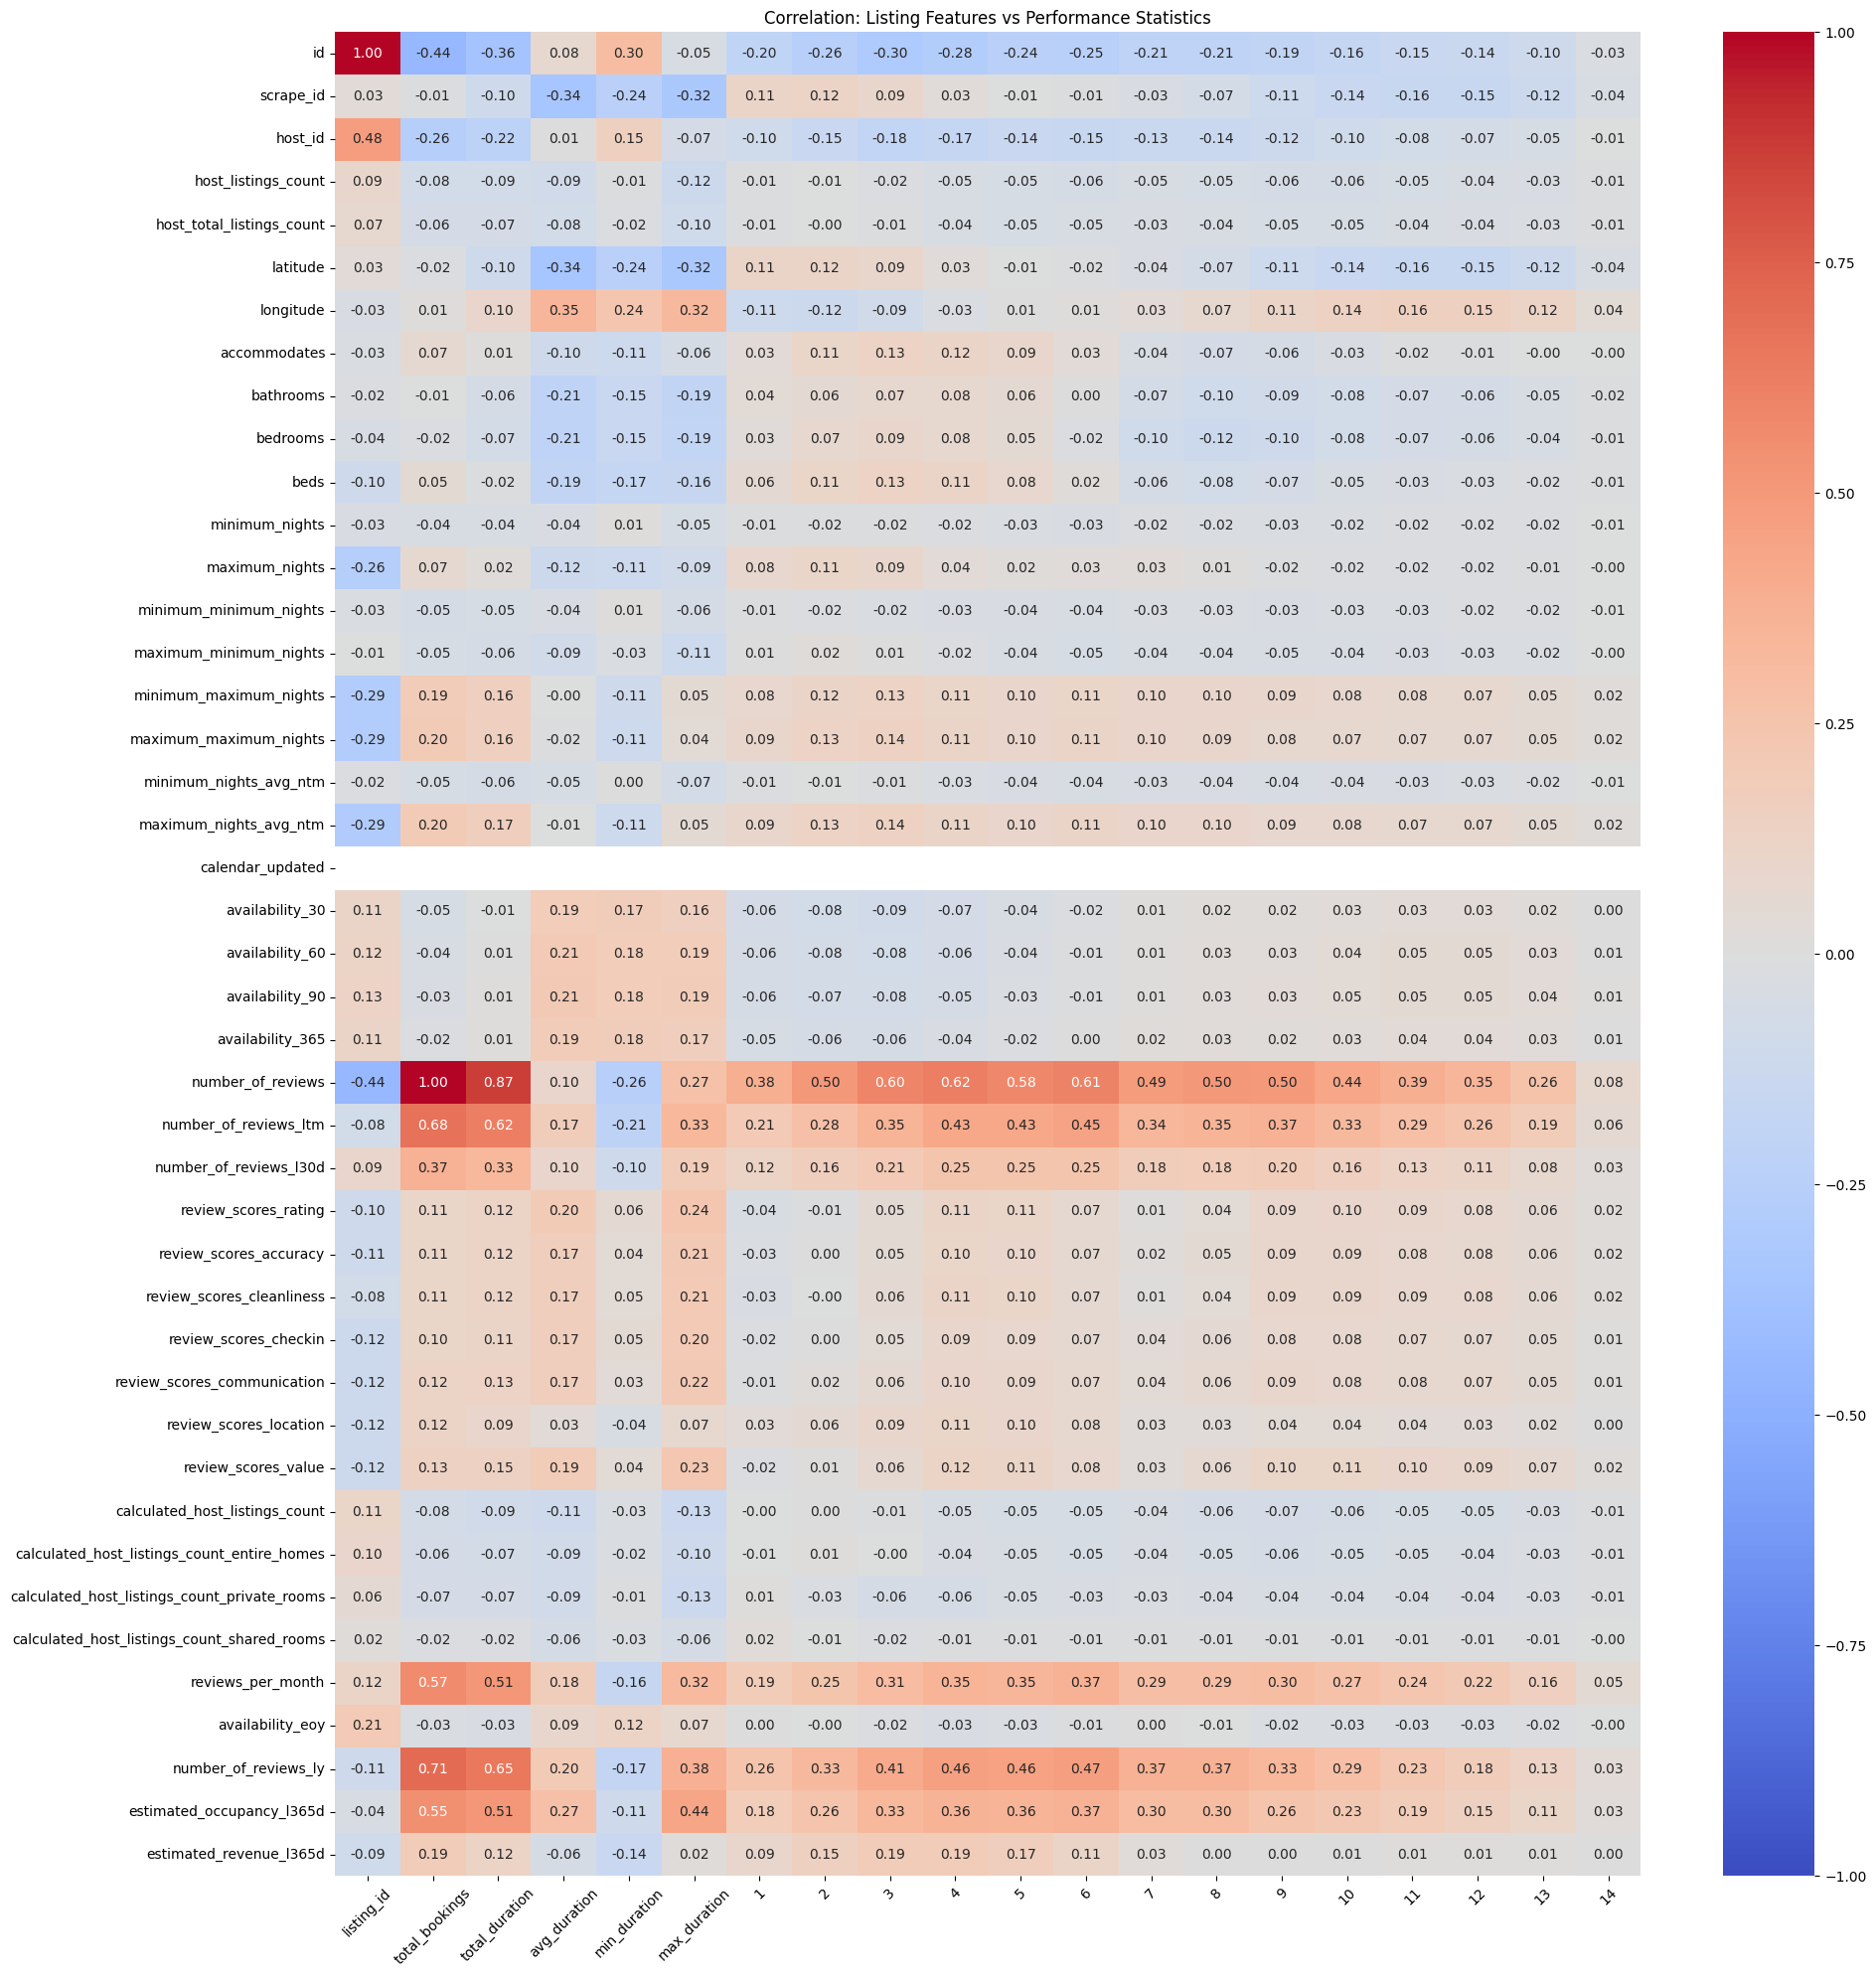

In [106]:
corr_matrix = merged_df.corr()

feature_to_stat_corr = corr_matrix.loc[numerical_columns, statistical_columns]

plt.figure(figsize=(20, 20))
sns.heatmap(feature_to_stat_corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation: Listing Features vs Performance Statistics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Mutual Information

In [ ]:
statistical_columns

Index([    'listing_id', 'total_bookings', 'total_duration',   'avg_duration',
         'min_duration',   'max_duration',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12,               13,               14],
      dtype='object')

In [146]:
mi_df = pd.merge(
    listings_statistics,
    booked_listings[numerical_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

# drop columns which contains NaN values
mi_df.drop(columns=mi_df.columns[mi_df.isnull().any()].tolist(), inplace=True)
mi_df.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_communication,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,5,0,4.86,4.89,4.97,1,1,0,0,0.19
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,6,0,4.96,4.97,4.92,1,1,0,0,0.68
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,31,1,4.95,4.98,4.93,1,1,0,0,0.28
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,0,0,4.61,4.88,4.89,1,1,0,0,0.14
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,49,2,4.95,4.94,4.93,13,13,0,0,3.58


In [131]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
import matplotlib.pyplot as plt

def compute_and_plot_mi(df, target_column, discrete_target=True, top_k=None):

    X = df.drop(columns=[target_column])
    y = df[target_column]

    numeric_cols = X.select_dtypes(include=['int', 'float']).columns
    X = X[numeric_cols]

    # Compute MI
    if discrete_target:
        mi = mutual_info_classif(X, y, discrete_features=False, random_state=42)
    else:
        mi = mutual_info_regression(X, y, discrete_features=False, random_state=42)

    mi_series = pd.Series(mi, index=X.columns)
    mi_series = mi_series.sort_values(ascending=False)

    if top_k:
        mi_series = mi_series.head(top_k)

    # Plot
    plt.figure(figsize=(20, 6))
    mi_series.plot(kind='bar')
    plt.title(f"Mutual Information with target = '{target_column}'")
    plt.ylabel("Mutual Information Score")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    return mi_series


Mutual Information for target: listing_id


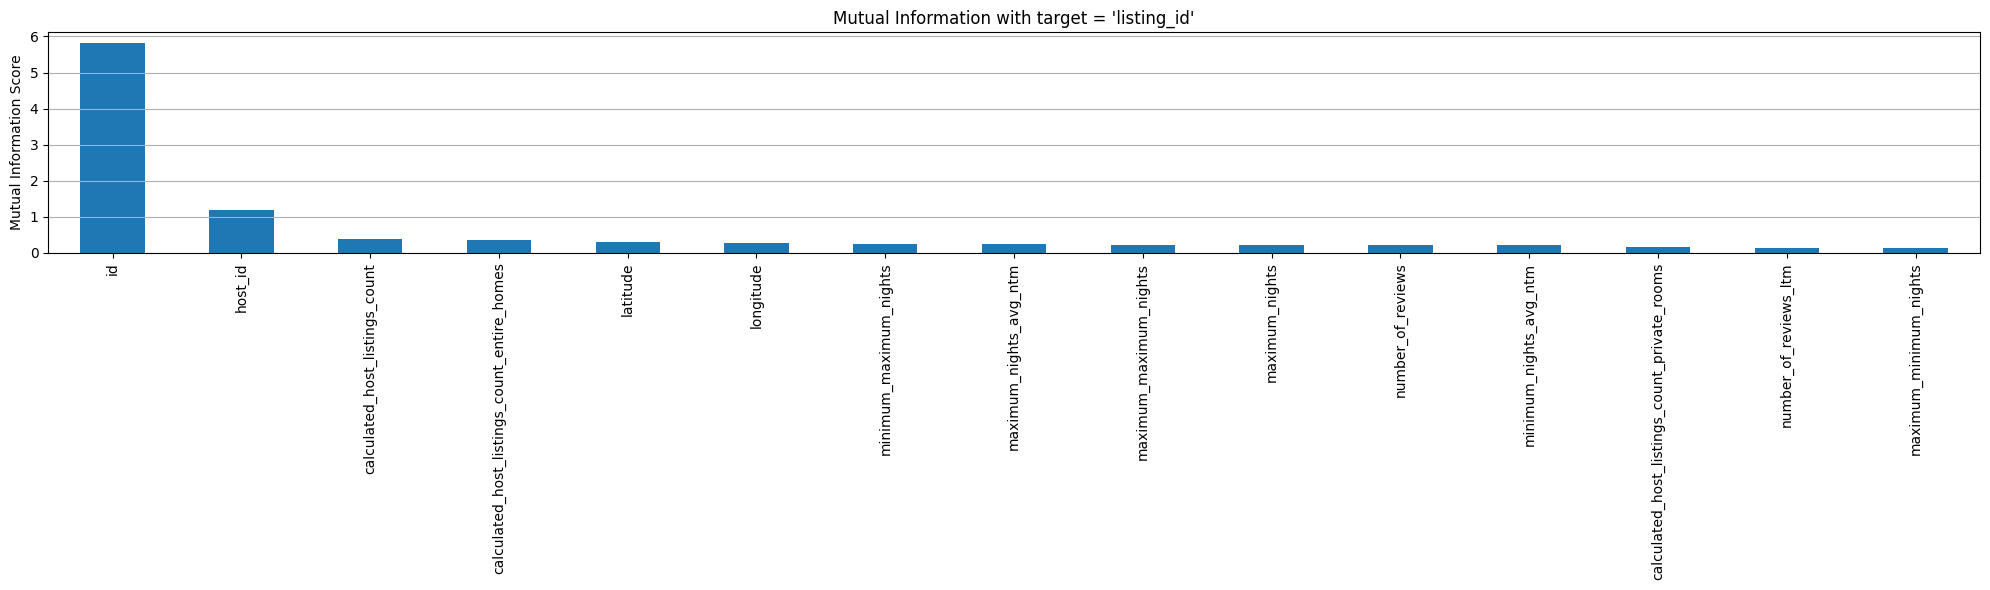

Mutual Information for target: total_bookings


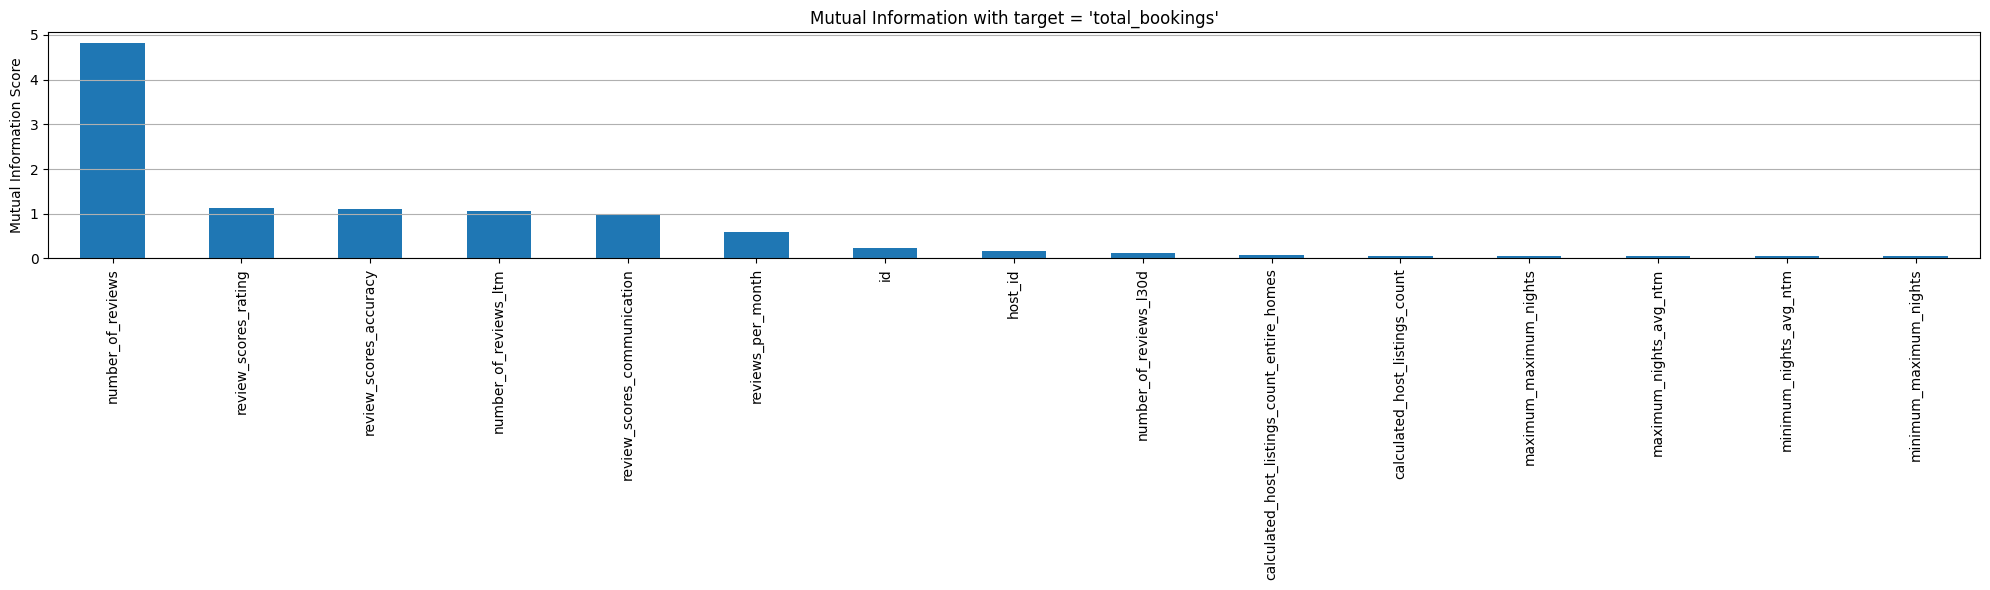

Mutual Information for target: total_duration


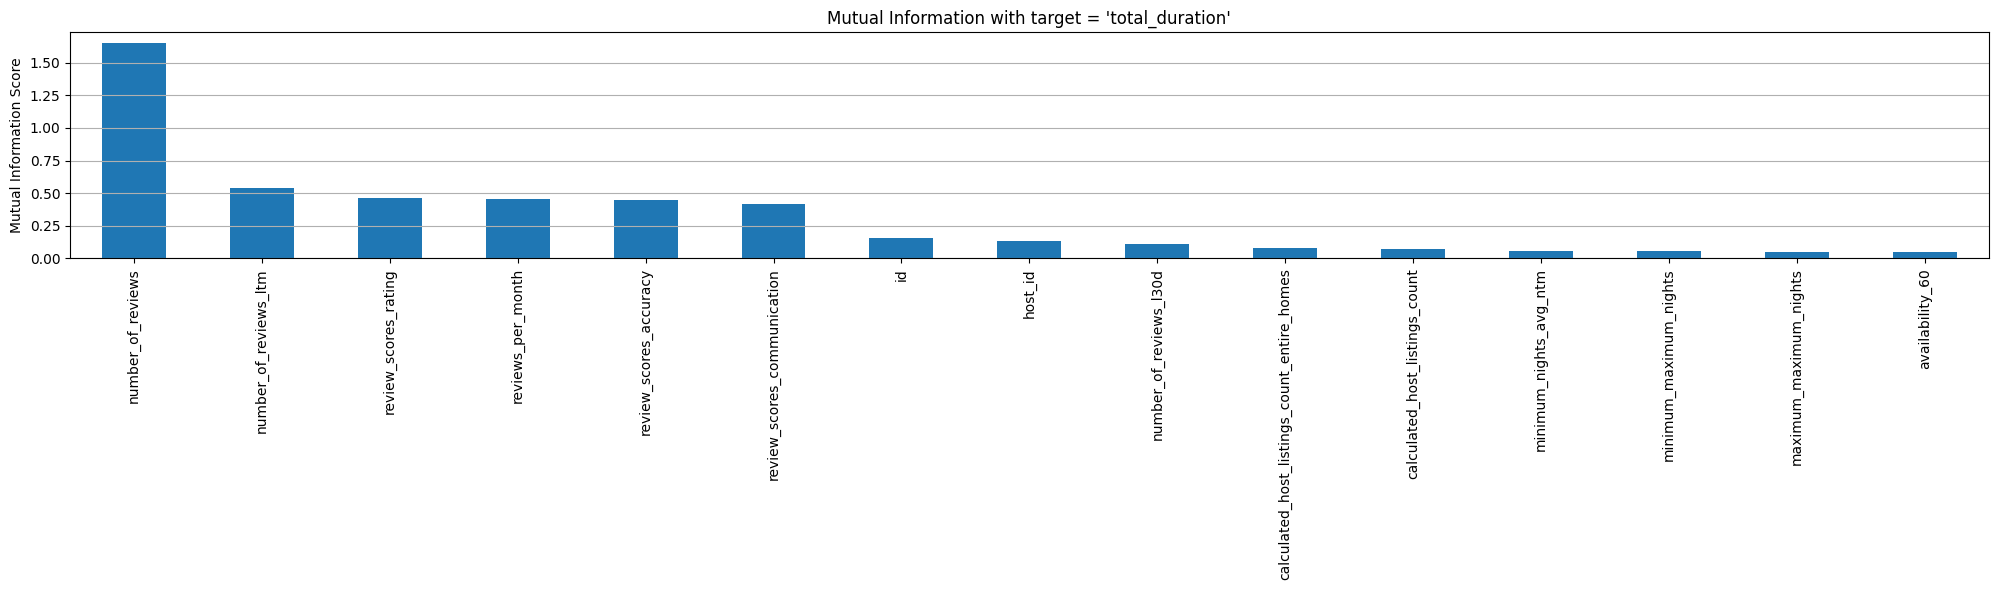

Mutual Information for target: avg_duration


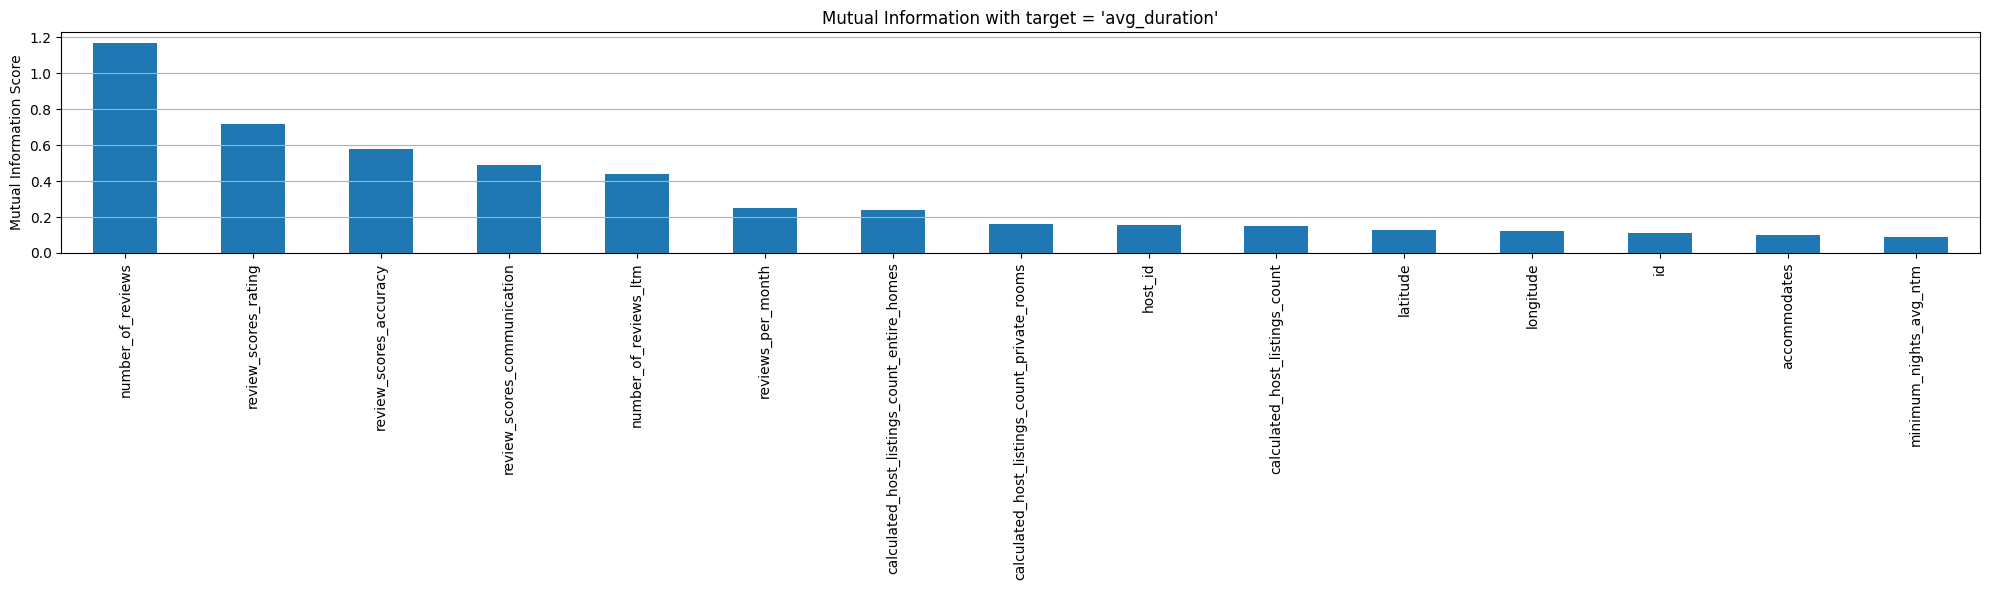

Mutual Information for target: min_duration


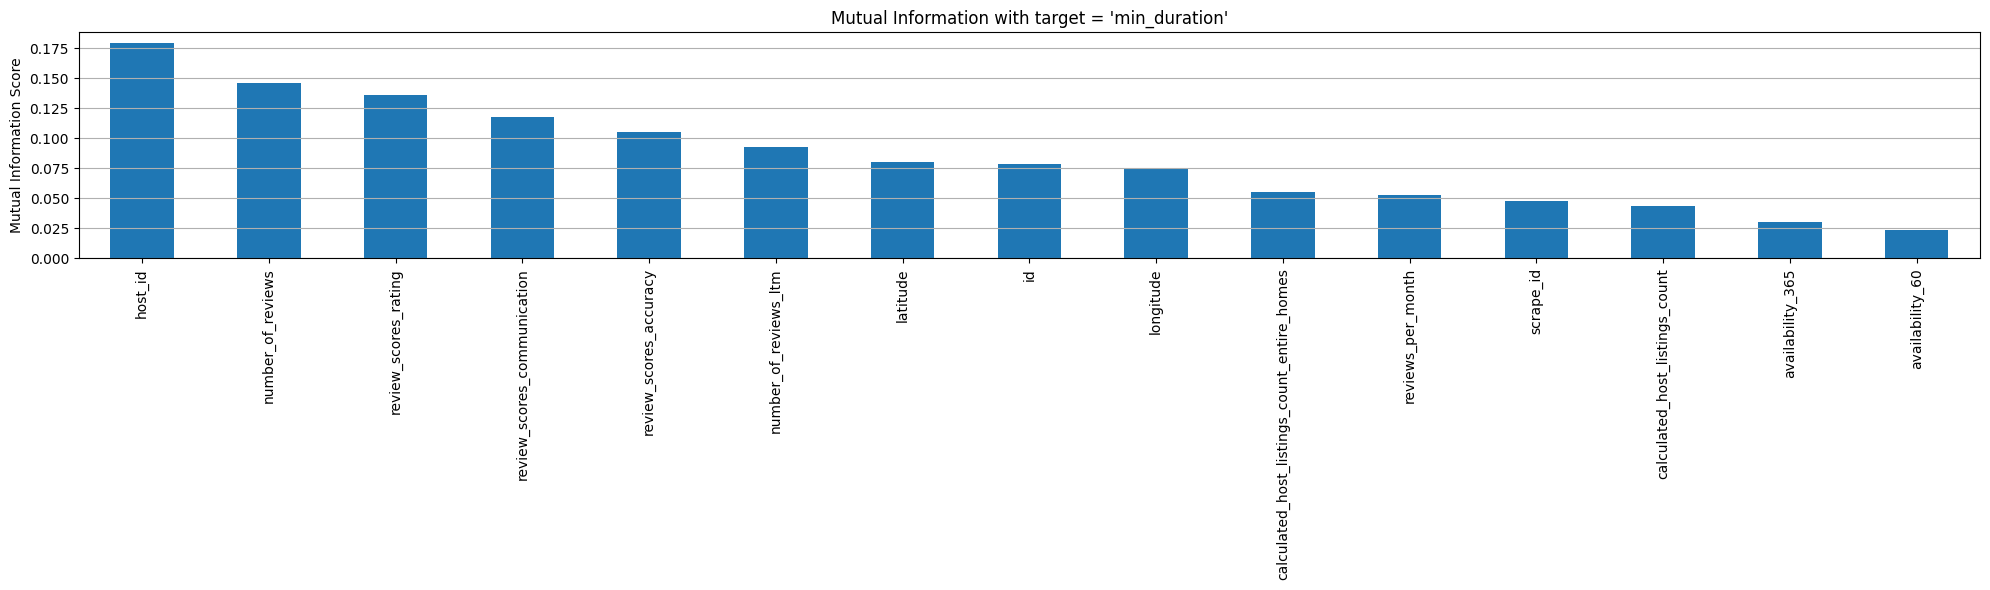

Mutual Information for target: max_duration


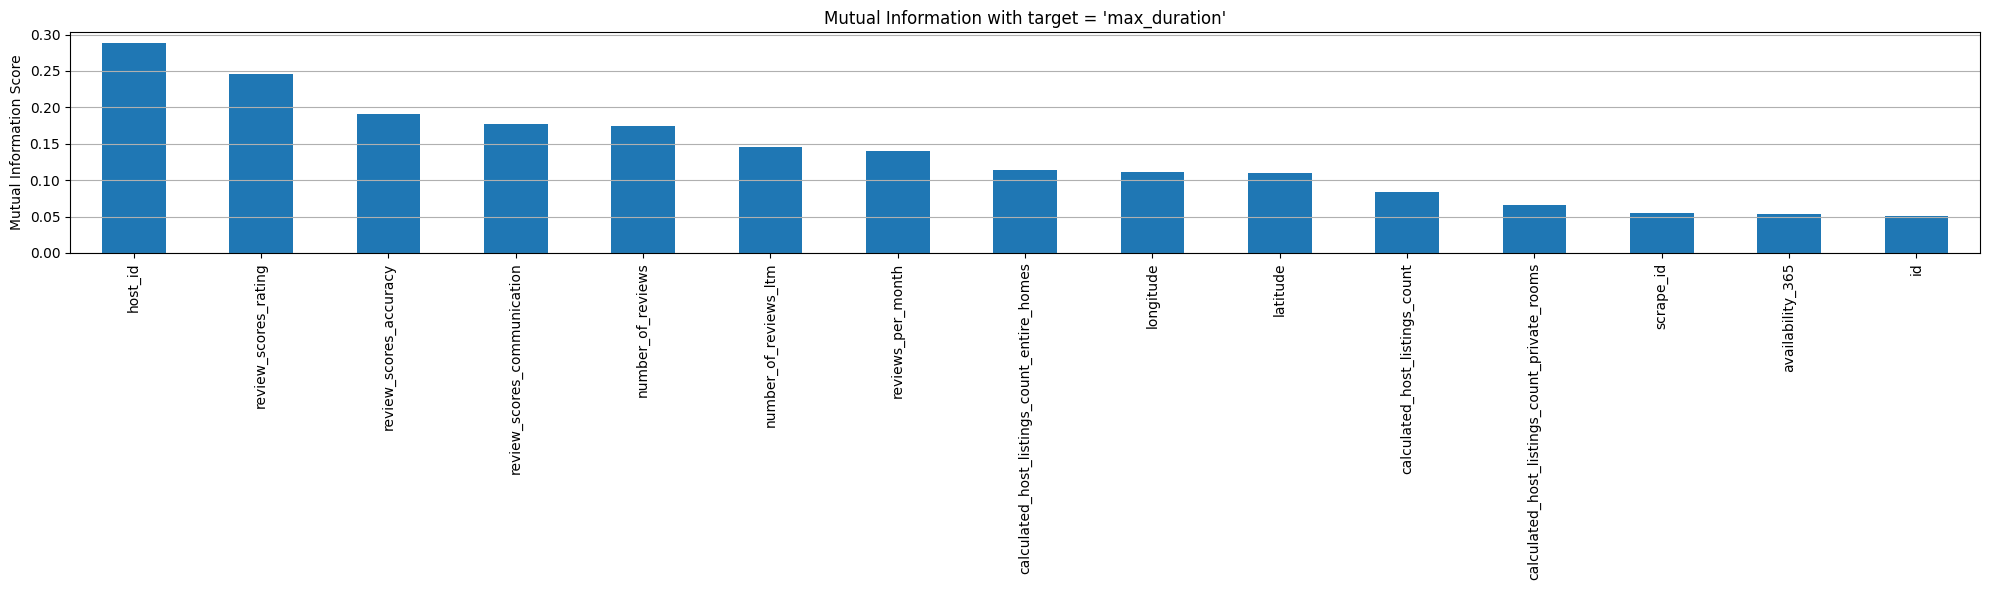

Mutual Information for target: 1


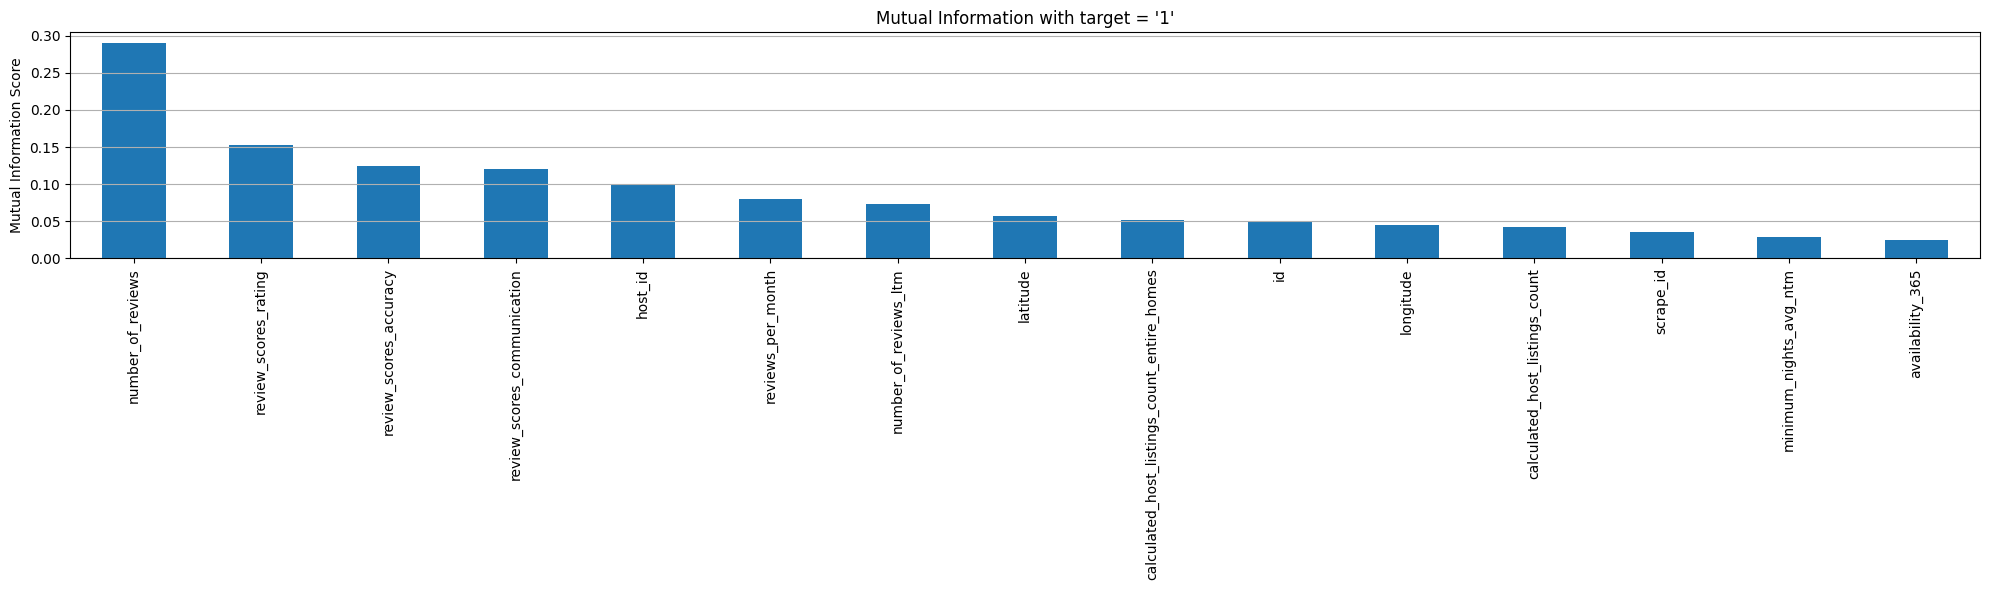

Mutual Information for target: 2


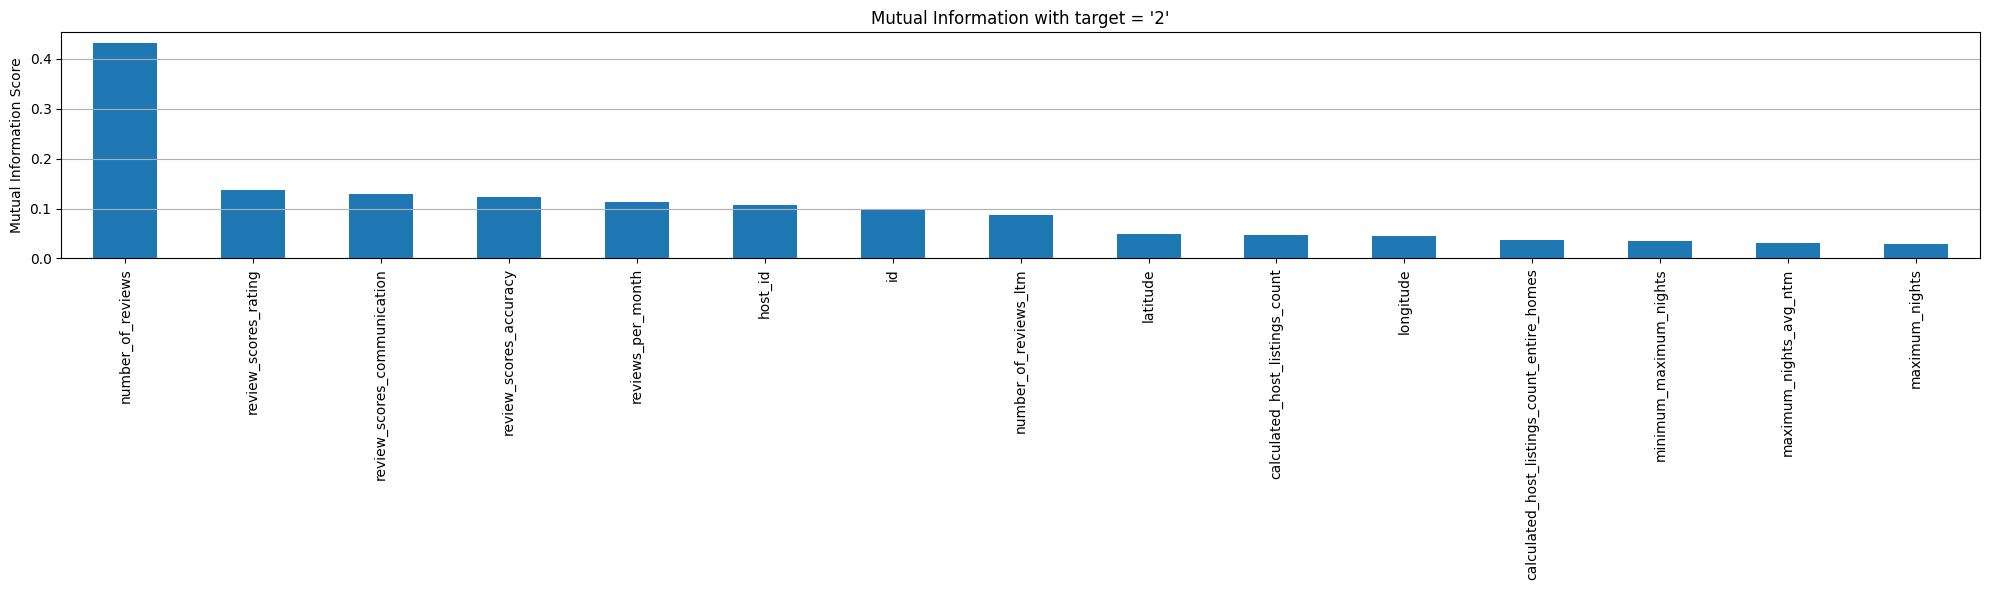

Mutual Information for target: 3


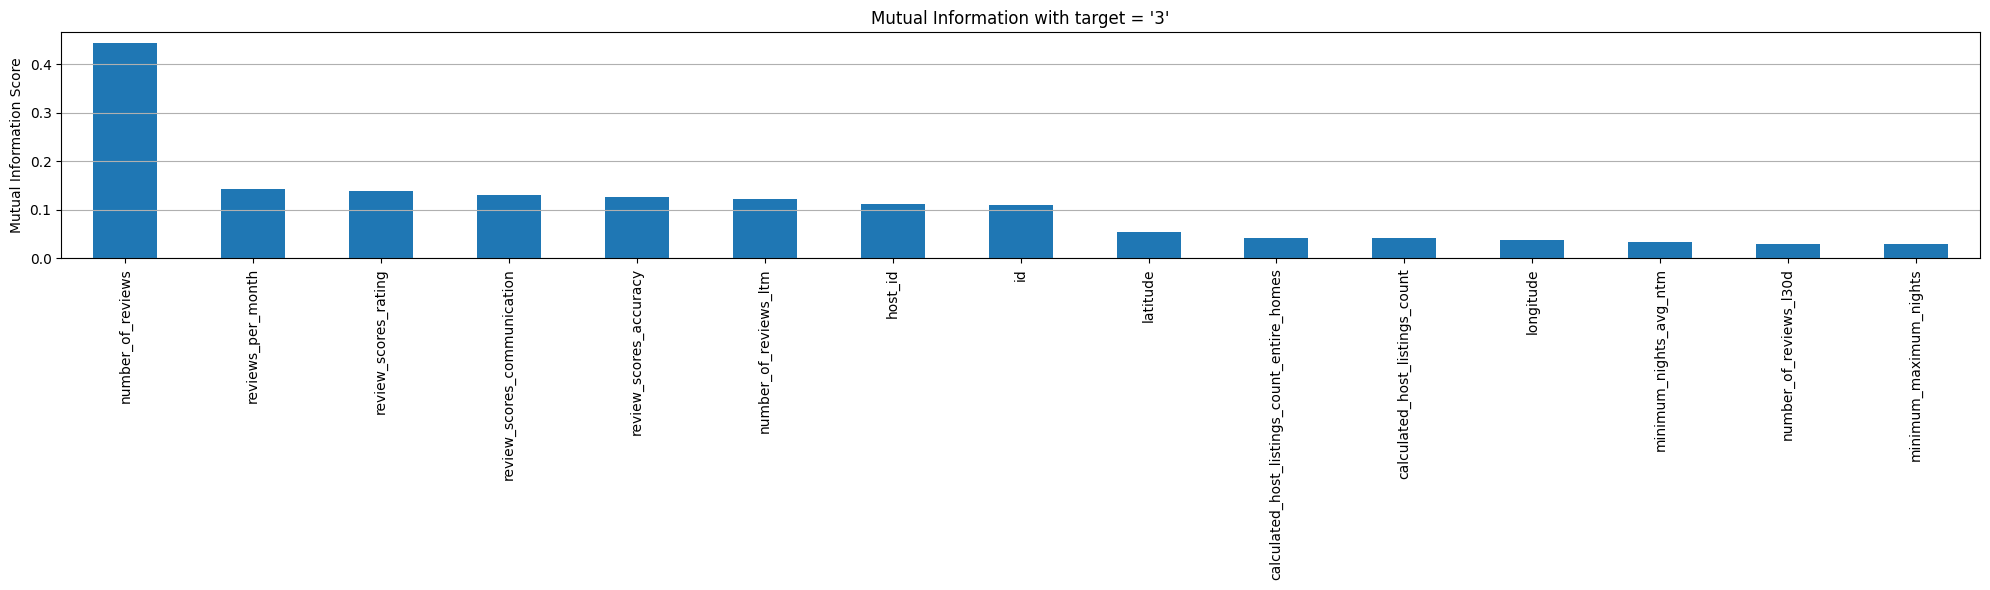

Mutual Information for target: 4


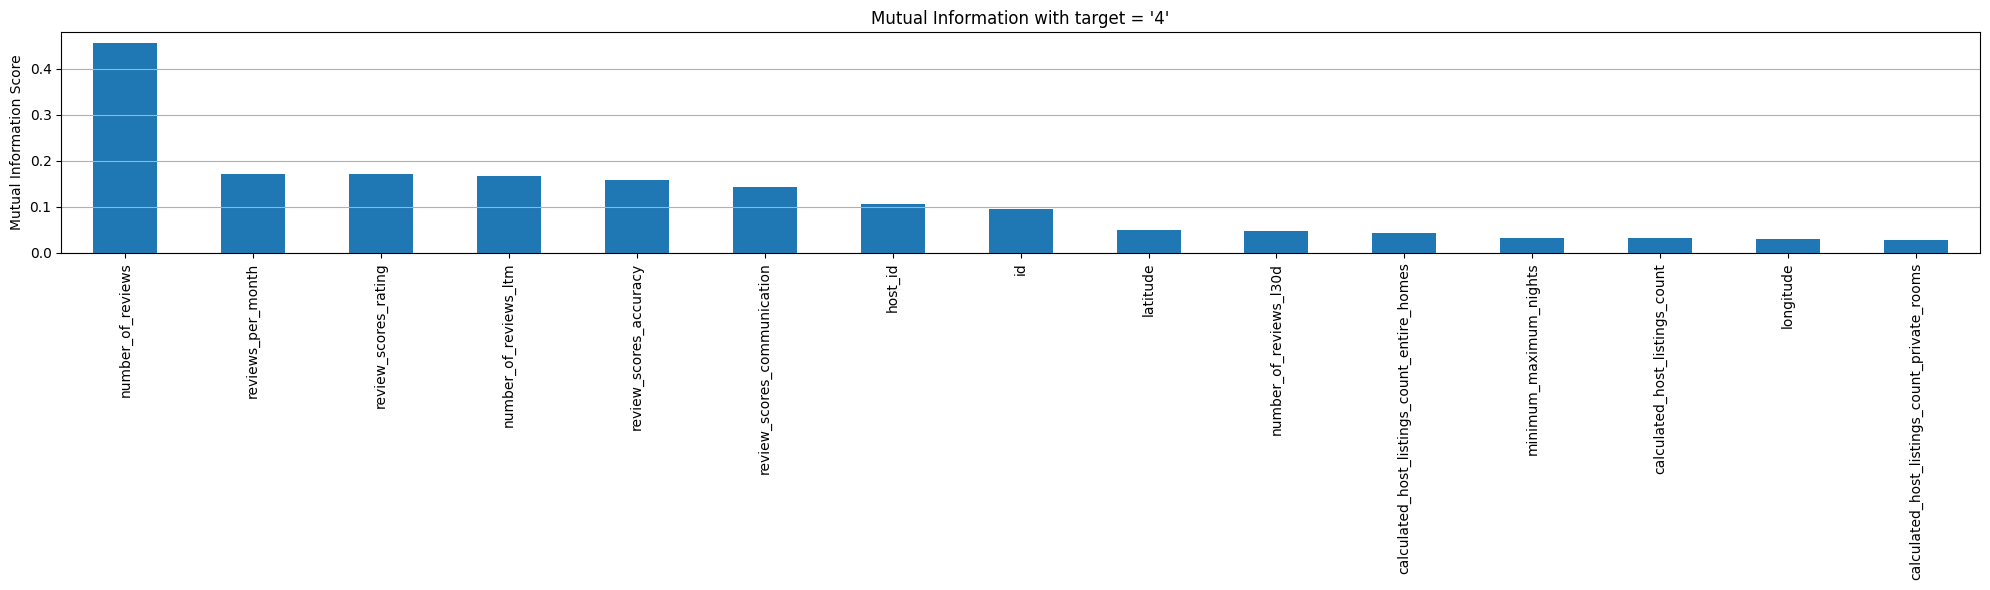

Mutual Information for target: 5


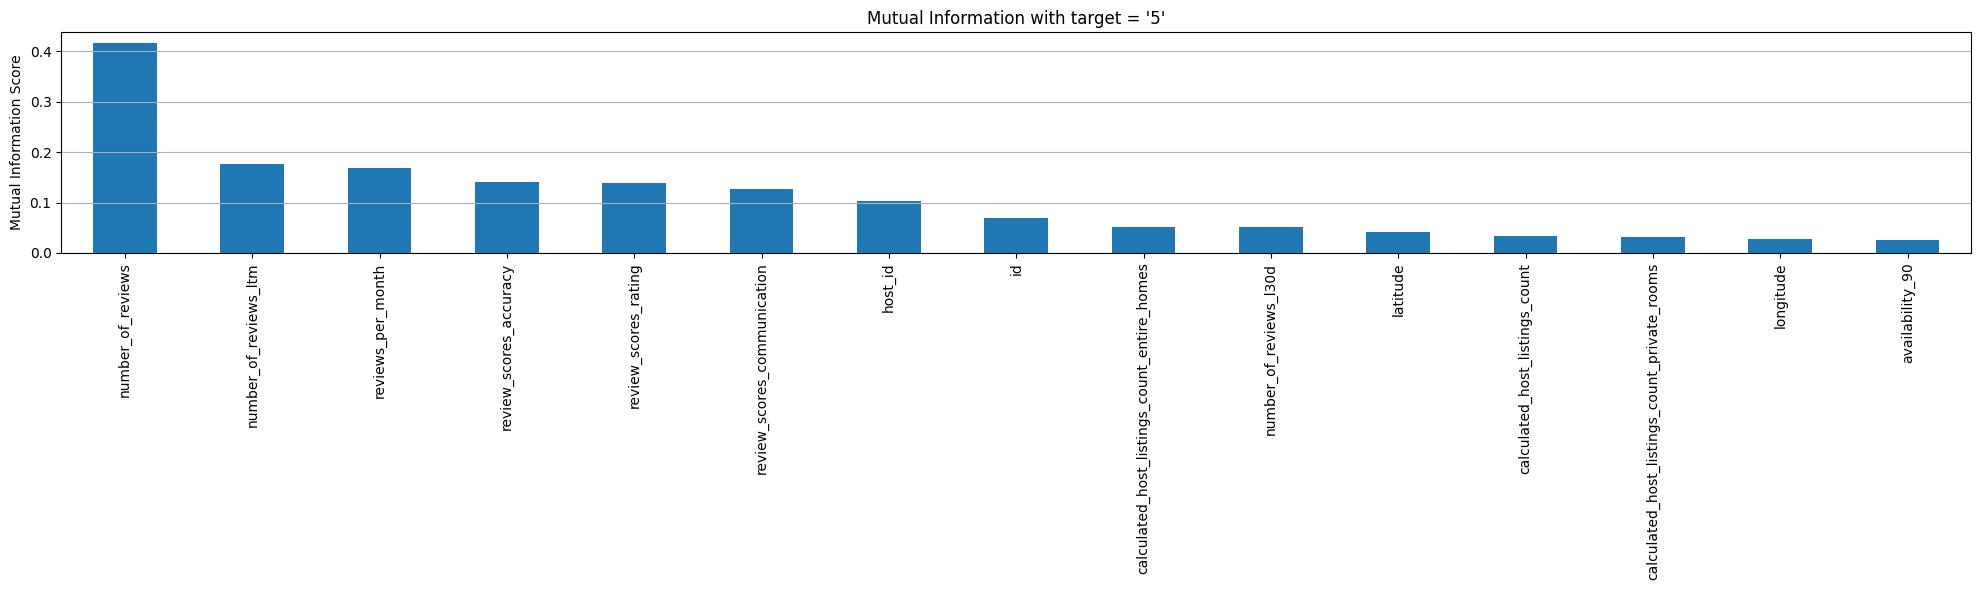

Mutual Information for target: 6


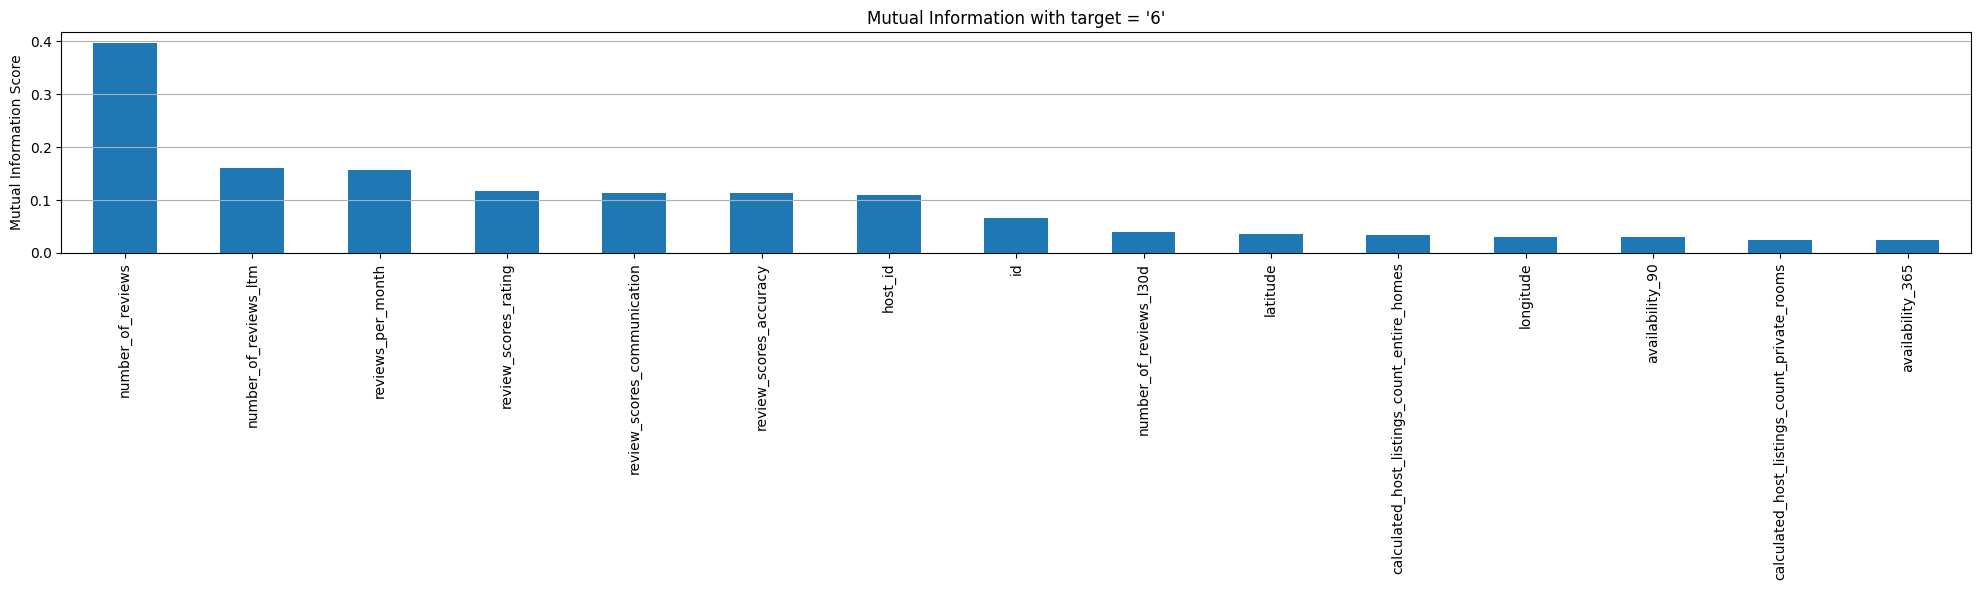

Mutual Information for target: 7


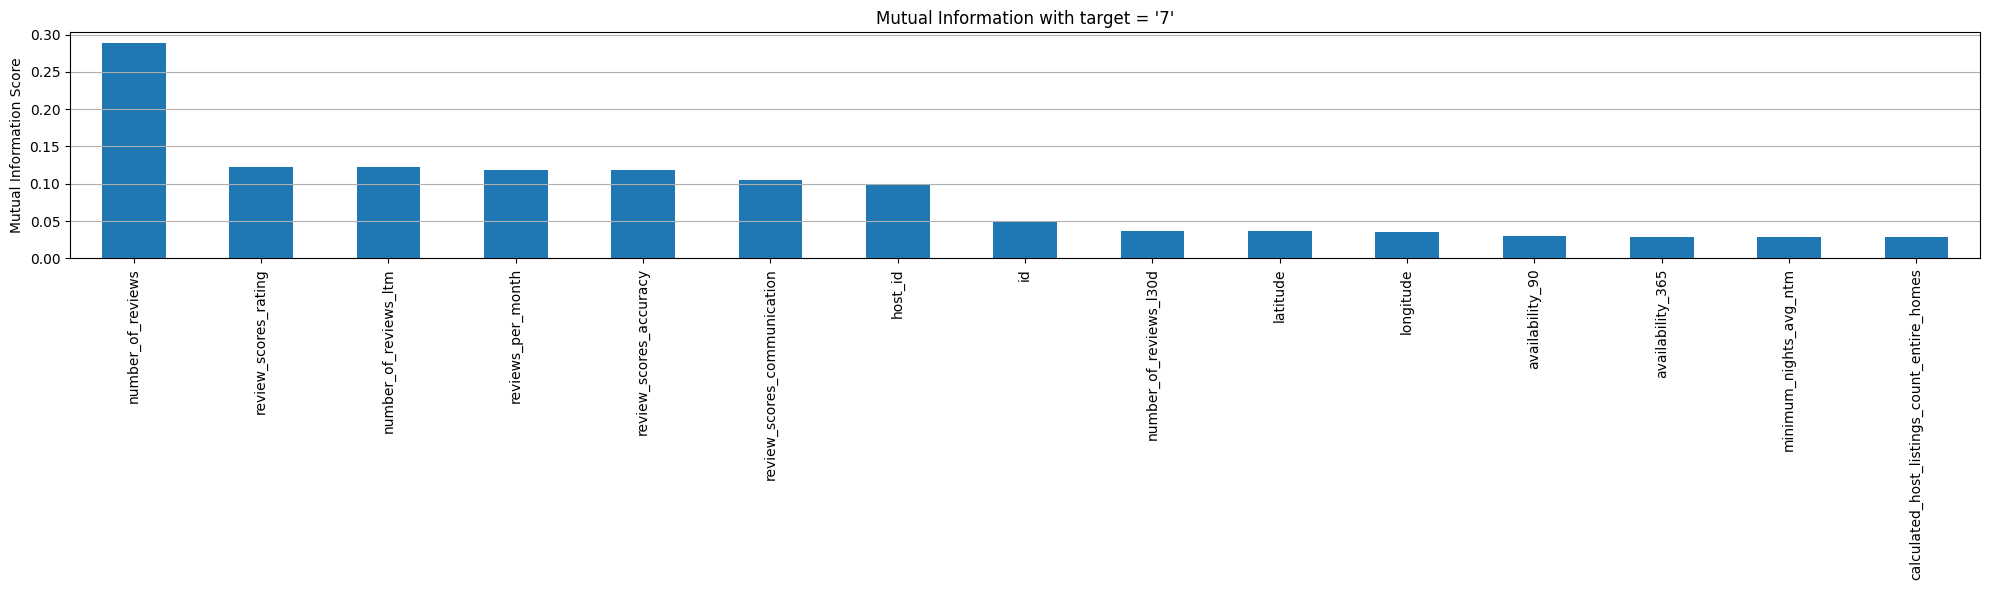

Mutual Information for target: 8


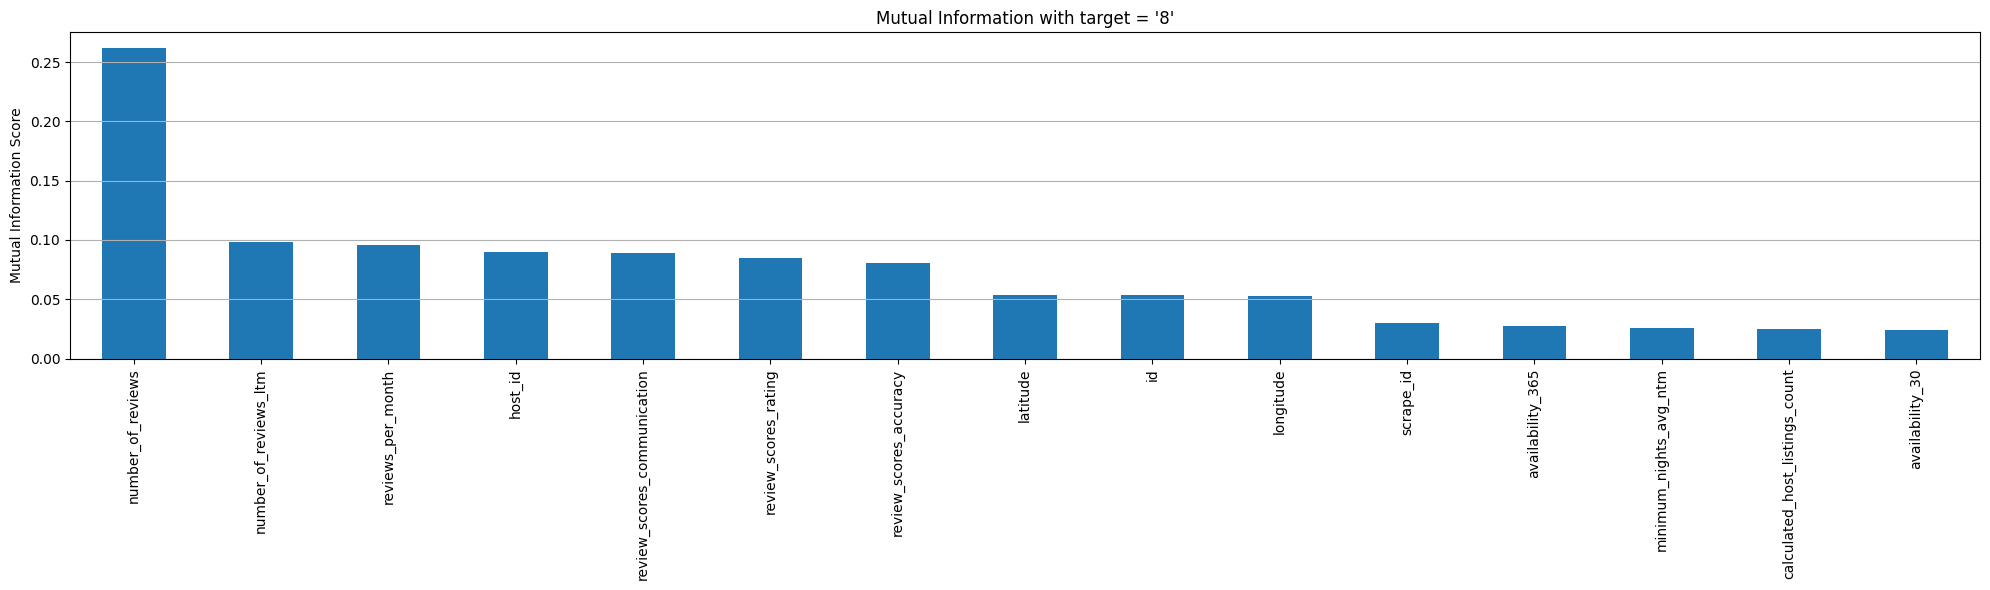

Mutual Information for target: 9


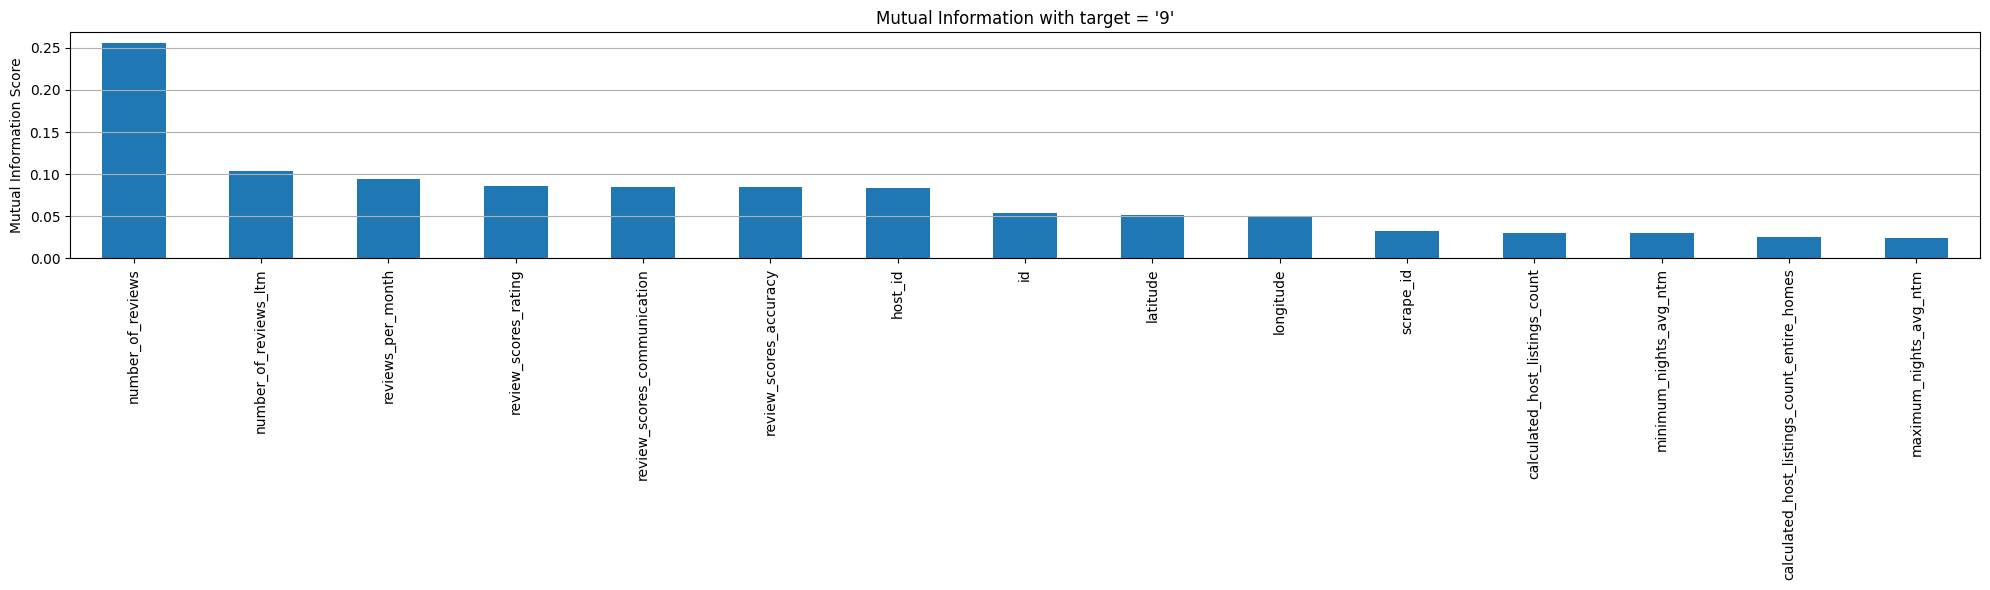

Mutual Information for target: 10


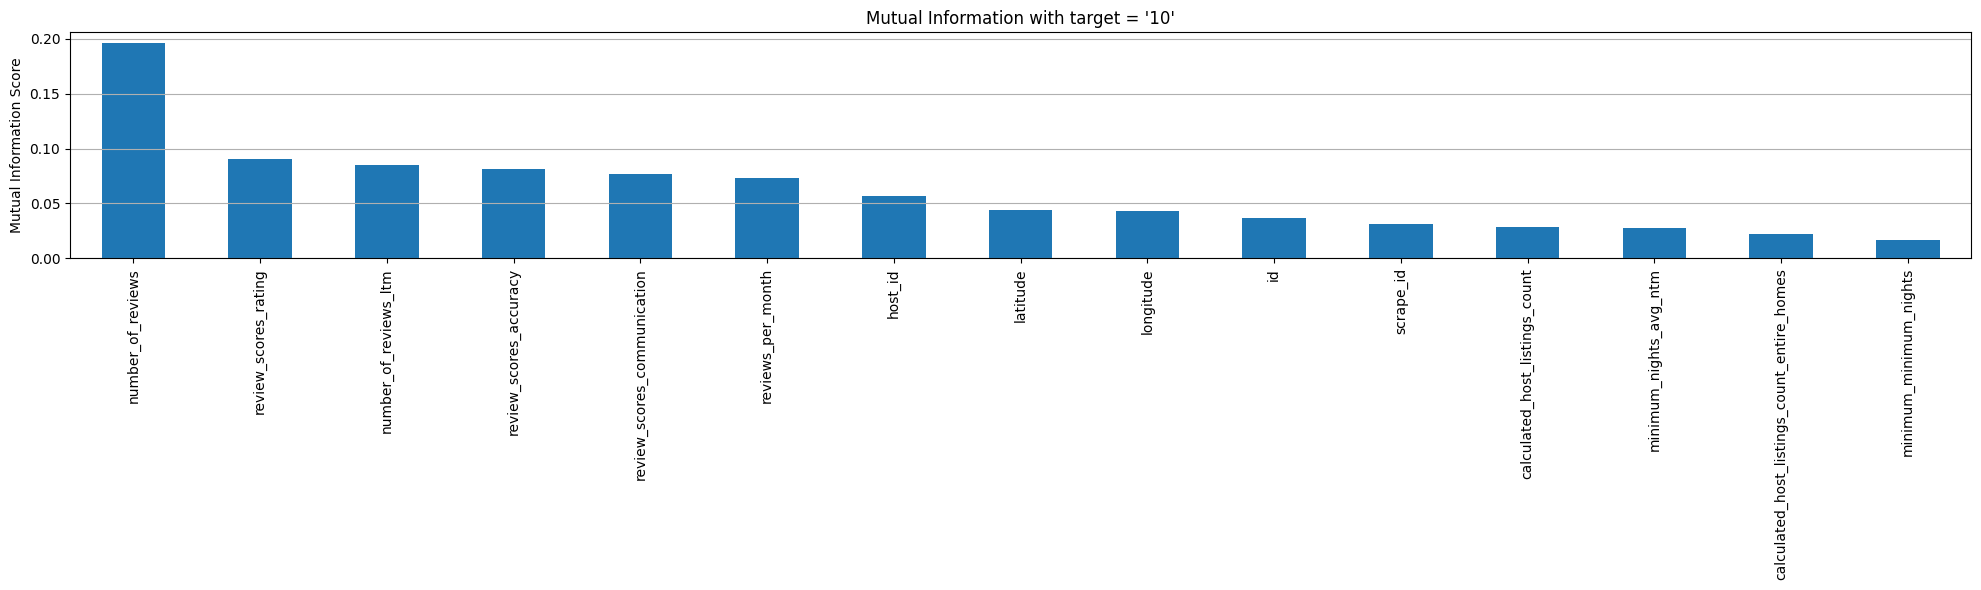

Mutual Information for target: 11


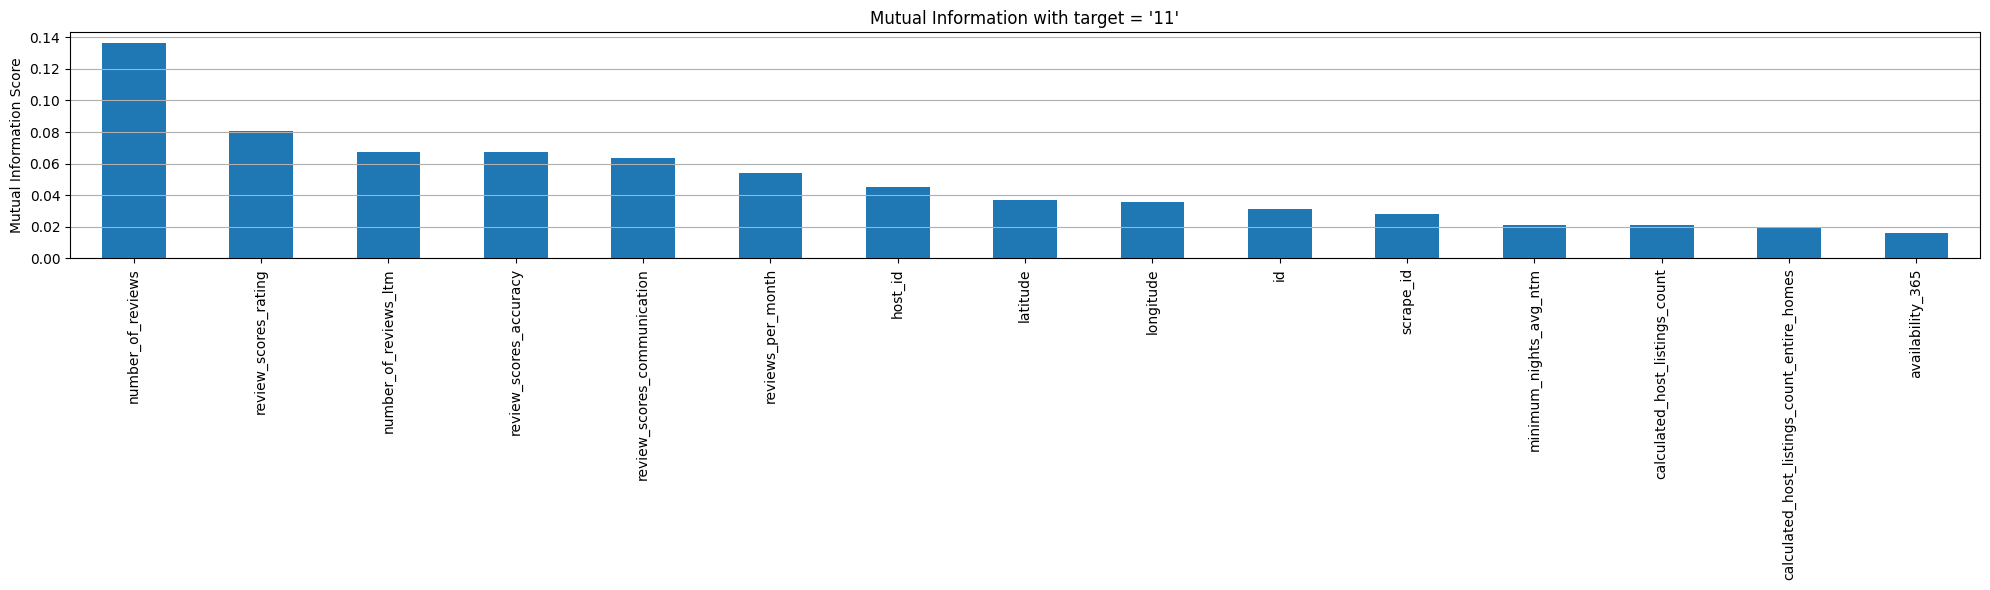

Mutual Information for target: 12


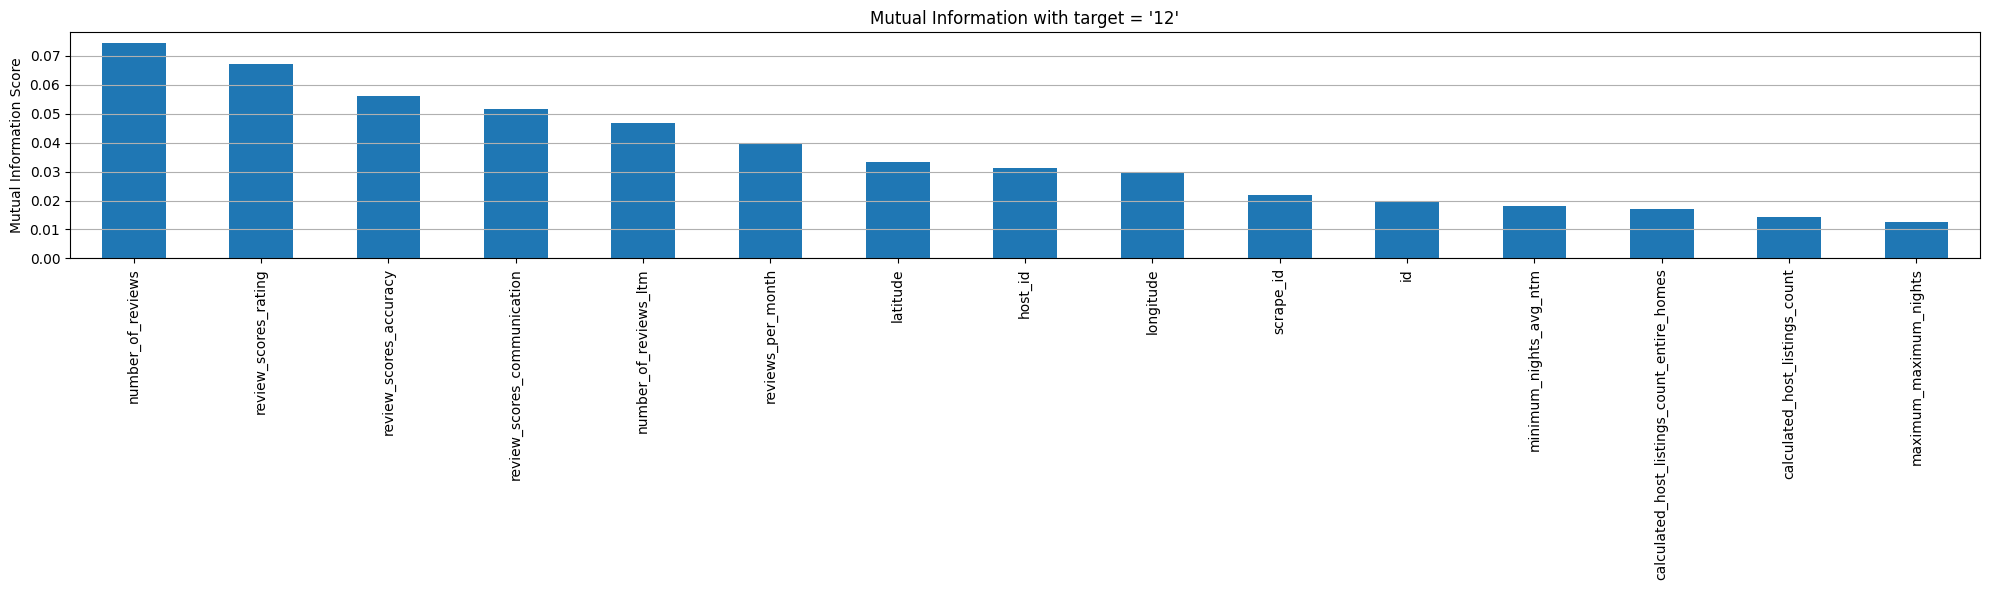

Mutual Information for target: 13


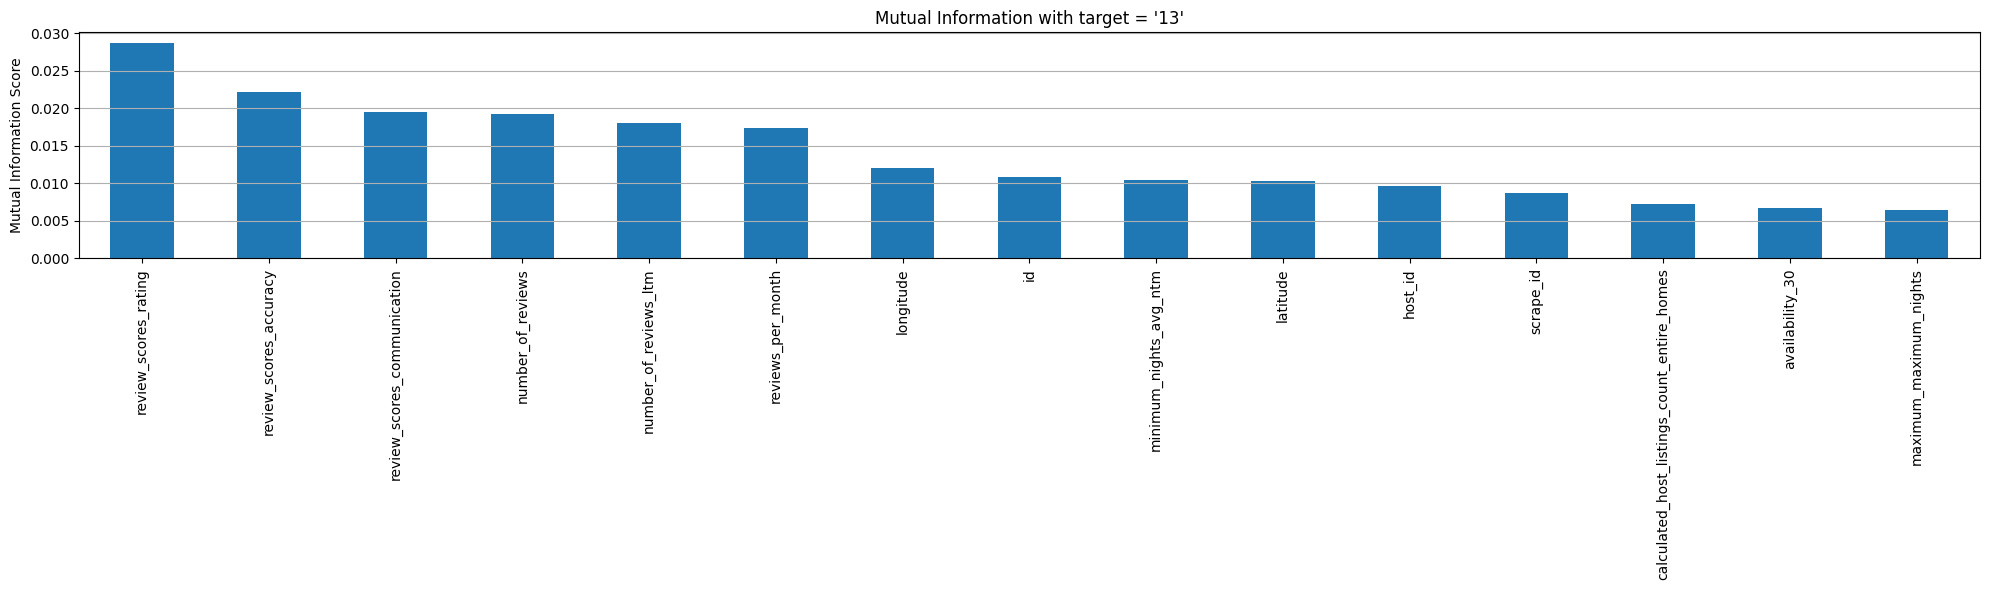

Mutual Information for target: 14


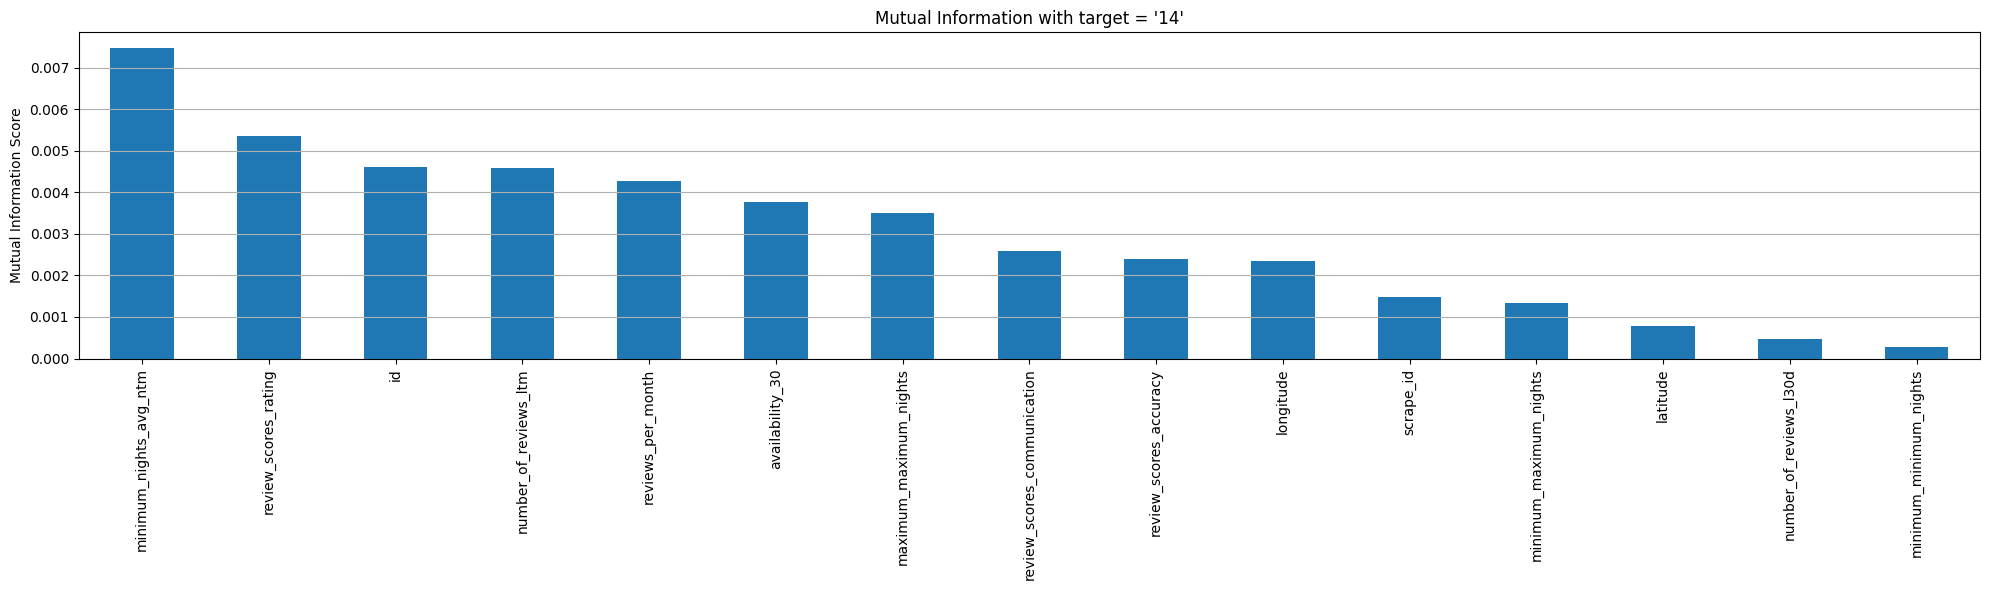

In [152]:
statistical_columns = mi_df.columns[:20]

for target in statistical_columns:
    df = mi_df.copy()
    col_to_drop = [col for col in statistical_columns if col != target]
    df.drop(columns=col_to_drop, inplace=True)

    print(f"Mutual Information for target: {target}")
    compute_and_plot_mi(df, target, discrete_target=False, top_k=15)

In [52]:
short_stay_columns = [k for k in range(1, 8)]  # 1 to 7
long_stay_columns = [k for k in range(8, 15)]  # 8 to 14

duration_counts['num_of_short_stays'] = duration_counts[short_stay_columns].sum(axis=1)
duration_counts['num_of_long_stays'] = duration_counts[long_stay_columns].sum(axis=1)

# Keep only the new columns
duration_counts = duration_counts[['num_of_short_stays', 'num_of_long_stays']]

# Merge with listings_statistics
listings_statistics = listings_statistics.merge(duration_counts, how='left', left_on='listing_id', right_index=True)
listings_statistics.fillna(0, inplace=True)

listings_statistics.drop(columns=[k for k in range(1, 15)], inplace=True)

# Convert to integers since these are counts
listings_statistics['num_of_short_stays'] = listings_statistics['num_of_short_stays'].astype(int)
listings_statistics['num_of_long_stays'] = listings_statistics['num_of_long_stays'].astype(int)

listings_statistics.head()


,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays
0,21853.0,33,48,1.454545,1,4,33,0
1,27262.0,29,144,4.965517,2,7,29,0
2,30320.0,172,360,2.093023,1,4,172,0
3,30959.0,8,12,1.500000,1,3,8,0
4,33945.0,78,540,6.923077,3,10,54,24


In [53]:
statistical_columns = listings_statistics.columns

merged_df = pd.merge(
    listings_statistics,
    booked_listings[numerical_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

merged_df.head(5)


,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,num_of_short_stays,num_of_long_stays,id,scrape_id,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d
0,27262.0,29,144,4.965517,2,7,29,0,27262,20241225065837,...,4.71,1,1,0,0,0.19,NaN,NaN,NaN,NaN
1,809874.0,97,288,2.969072,1,5,97,0,809874,20241225065837,...,4.91,1,1,0,0,0.68,NaN,NaN,NaN,NaN
2,866381.0,40,383,9.575000,3,12,4,36,866381,20241225065837,...,4.90,1,1,0,0,0.28,NaN,NaN,NaN,NaN
3,886724.0,18,115,6.388889,3,9,15,3,886724,20241225065837,...,4.72,1,1,0,0,0.14,NaN,NaN,NaN,NaN
4,896212.0,515,4979,9.667961,2,13,35,480,896212,20241225065837,...,4.93,13,13,0,0,3.58,NaN,NaN,NaN,NaN


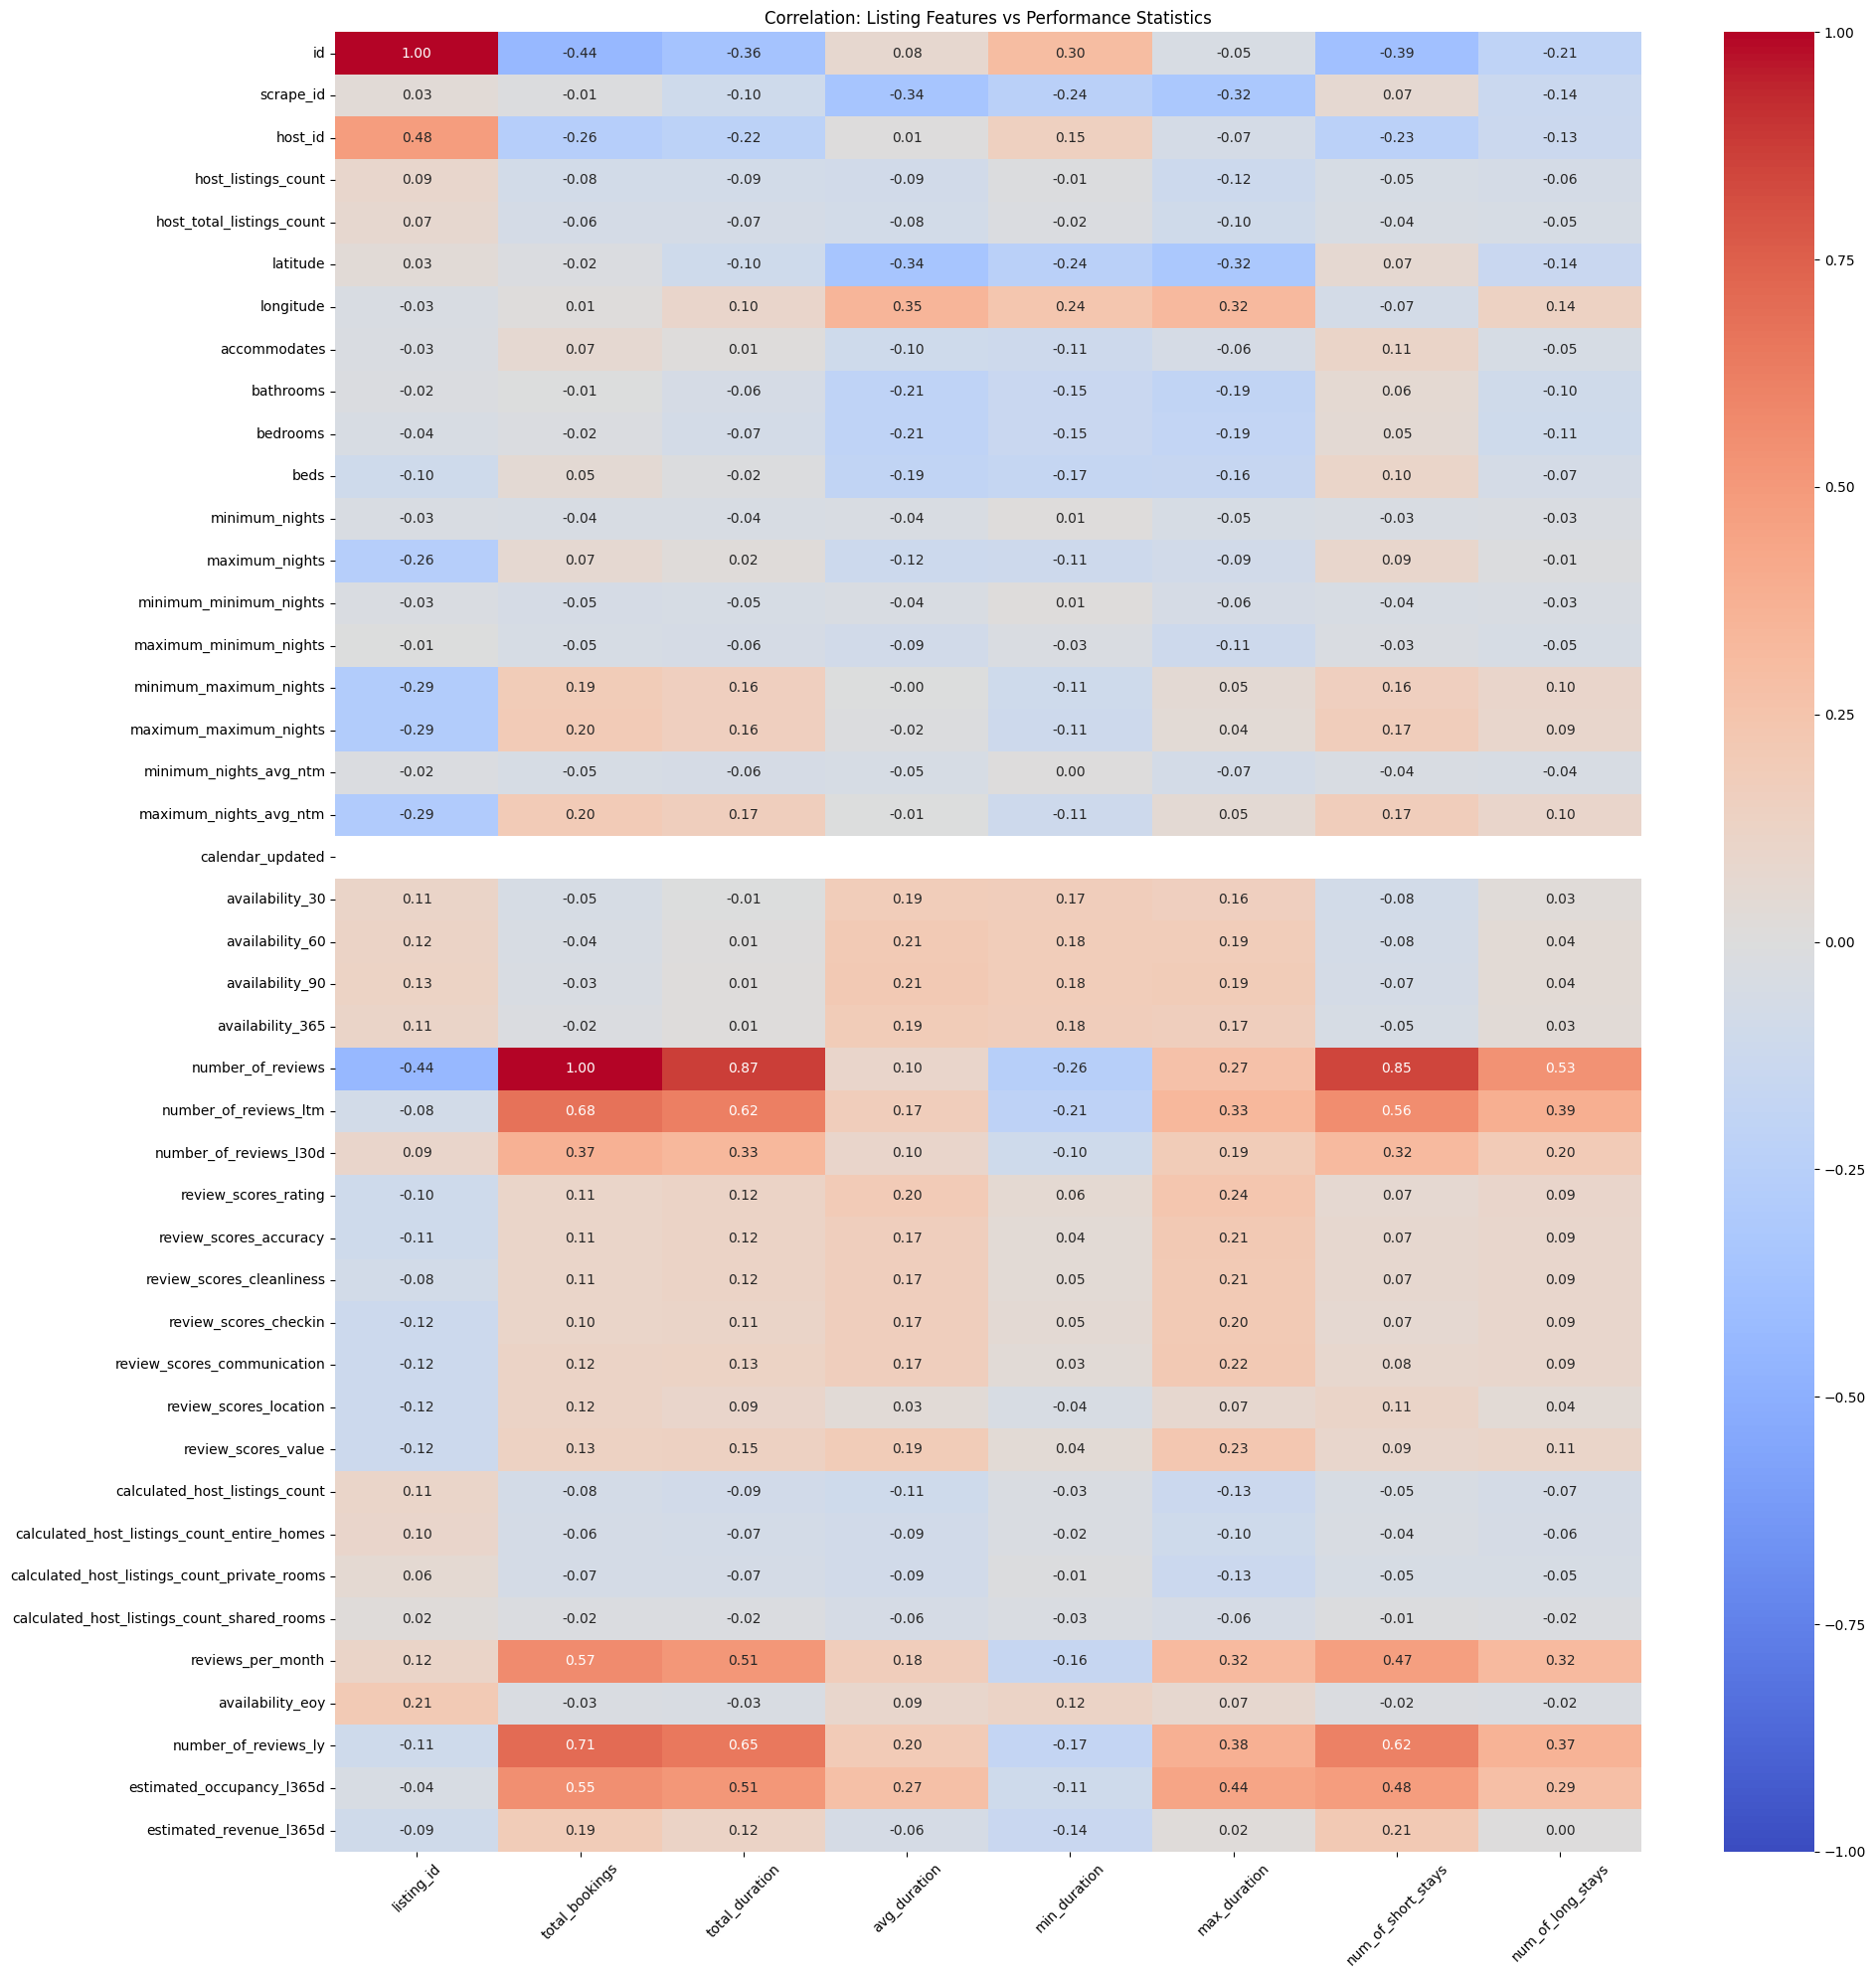

In [54]:
corr_matrix = merged_df.corr()

feature_to_stat_corr = corr_matrix.loc[numerical_columns, statistical_columns]

plt.figure(figsize=(20, 20))
sns.heatmap(feature_to_stat_corr,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation: Listing Features vs Performance Statistics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Cena
- porównanie ceny za noc do średniej wynajmu

In [164]:
statistical_columns

Index([    'listing_id', 'total_bookings', 'total_duration',   'avg_duration',
         'min_duration',   'max_duration',                1,                2,
                      3,                4,                5,                6,
                      7,                8,                9,               10,
                     11,               12,               13,               14],
      dtype='object')

In [ ]:
merged_df = pd.merge(
    listings_statistics,
    booked_listings,
    left_on='listing_id',
    right_on='id',
    how='right'
)


selected_columns = list(merged_df.columns[:20])
if 'price' not in selected_columns:
    selected_columns.append('price')

print("Selected columns:", selected_columns)

Selected columns: ['listing_id', 'total_bookings', 'total_duration', 'avg_duration', 'min_duration', 'max_duration', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'price']


In [186]:
price_stats = merged_df[selected_columns]
price_stats['price'] = price_stats['price'].str.replace('[$,]', '', regex=True).astype(float)
price_stats.head()

/tmp/ipykernel_373/896731002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_stats['price'] = price_stats['price'].str.replace('[$,]', '', regex=True).astype(float)


,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,6,7,8,9,10,11,12,13,14,price
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,10,1,0,0,0,0,0,0,0,131.0
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,0,0,0,0,0,0,0,0,0,108.0
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,1,2,2,9,13,11,1,0,0,85.0
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,8,5,1,2,0,0,0,0,0,56.0
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,5,11,37,108,185,122,27,1,0,63.0


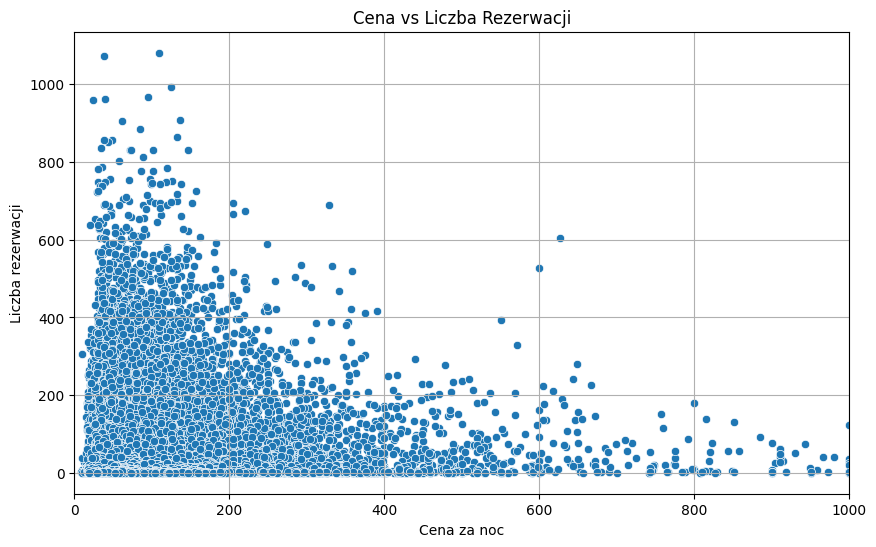

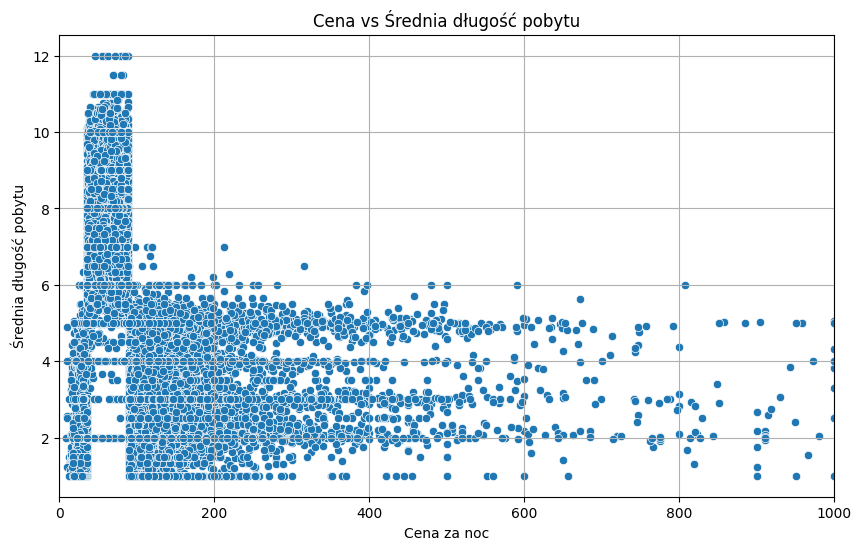

In [195]:

# Scatter plot: Cena vs liczba rezerwacji
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='total_bookings', data=price_stats)
plt.title("Cena vs Liczba Rezerwacji")
plt.xlabel("Cena za noc")
plt.ylabel("Liczba rezerwacji")
plt.xlim(0, 1000)
plt.grid(True)
plt.show()

# Scatter plot: Cena vs średnia długość pobytu
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='avg_duration', data=price_stats)
plt.title("Cena vs Średnia długość pobytu")
plt.xlabel("Cena za noc")
plt.xlim(0, 1000)
plt.ylabel("Średnia długość pobytu")
plt.grid(True)
plt.show()


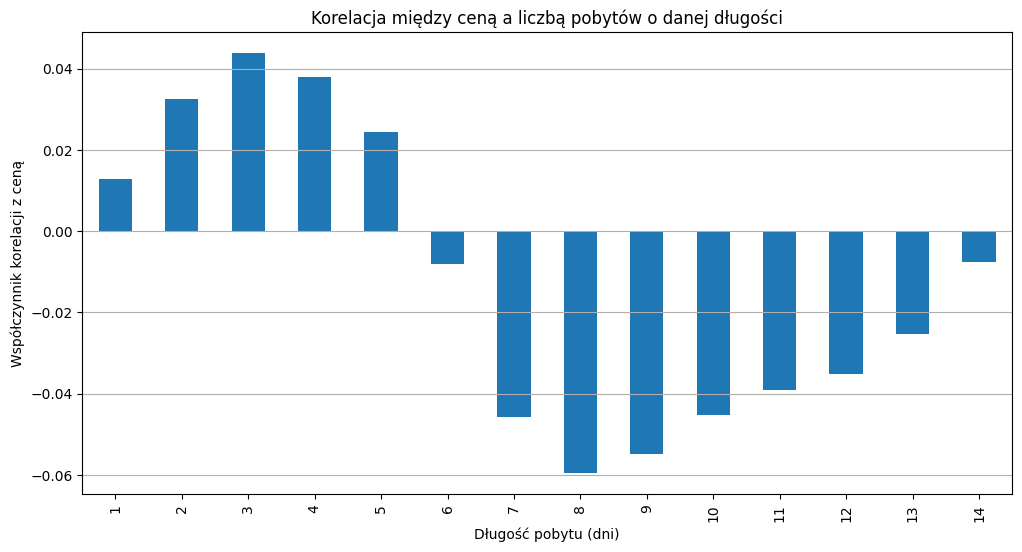

In [198]:
day_cols = list(range(1, 15))
corrs = price_stats[day_cols + ['price']].corr()['price'][day_cols].sort_index()

# Wykres słupkowy
plt.figure(figsize=(12, 6))
corrs.plot(kind='bar')
plt.title("Korelacja między ceną a liczbą pobytów o danej długości")
plt.xlabel("Długość pobytu (dni)")
plt.ylabel("Współczynnik korelacji z ceną")
plt.grid(axis='y')
plt.show()

### Korelacje danych kateogrycznych

In [202]:
print(non_numerical_columns)

['listing_url', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'amenities', 'price', 'has_availability', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'instant_bookable']


In [206]:
intresting_columns = ['id','property_type', 'room_type', 'bathrooms_text']

merged_df = pd.merge(
    listings_statistics,
    booked_listings[intresting_columns],
    left_on='listing_id',
    right_on='id',
    how='right'
)

merged_df.drop(columns=['id'], inplace=True)
merged_df.head(5)

,listing_id,total_bookings,total_duration,avg_duration,min_duration,max_duration,1,2,3,4,...,8,9,10,11,12,13,14,property_type,room_type,bathrooms_text
0,27262.0,29,144,4.965517,2,7,0,1,2,6,...,0,0,0,0,0,0,0,Entire rental unit,Entire home/apt,1 bath
1,809874.0,97,288,2.969072,1,5,6,23,39,26,...,0,0,0,0,0,0,0,Entire rental unit,Entire home/apt,1 bath
2,866381.0,40,383,9.575000,3,12,0,0,1,0,...,2,9,13,11,1,0,0,Entire condo,Entire home/apt,1 bath
3,886724.0,18,115,6.388889,3,9,0,0,2,0,...,1,2,0,0,0,0,0,Entire rental unit,Entire home/apt,1 bath
4,896212.0,515,4979,9.667961,2,13,0,2,4,6,...,37,108,185,122,27,1,0,Entire rental unit,Entire home/apt,1 bath


In [207]:
property_types = merged_df['property_type'].unique()
room_types = merged_df['room_type'].unique()
bathrooms_text = merged_df['bathrooms_text'].unique()
print(f"Property Types: {property_types}")
print(f"Room Types: {room_types}")
print(f"Bathrooms Text: {bathrooms_text}")

Property Types: ['Entire rental unit' 'Entire condo' 'Entire home' 'Earthen home'
 'Entire loft' 'Tiny home' 'Private room in home'
 'Private room in rental unit' 'Entire guest suite' 'Entire townhouse'
 'Private room in condo' 'Entire cottage' 'Entire serviced apartment'
 'Room in hotel' 'Entire guesthouse' 'Room in aparthotel' 'Entire villa'
 'Entire place' 'Private room in hostel' 'Private room in floor'
 'Room in boutique hotel' 'Private room in guest suite'
 'Private room in serviced apartment' 'Room in serviced apartment'
 'Private room in townhouse' 'Shared room in hostel' 'Camper/RV'
 'Entire vacation home' 'Casa particular'
 'Private room in casa particular' 'Private room in bed and breakfast'
 'Private room in guesthouse' 'Shared room in condo' 'Cycladic home'
 'Shared room in bed and breakfast' 'Private room in tent'
 'Shared room in hotel' 'Private room in chalet' 'Entire bungalow'
 'Private room in loft' 'Religious building' 'Floor' 'Private room' 'Hut'
 'Shared room in re

In [220]:
def sort_categorcal_values(column_name):
    avg_duration_by_feature = merged_df.groupby(
        column_name
    )['avg_duration'].mean().reset_index()

    # Sortowanie wyników (opcjonalne)
    avg_duration_by_features_sorted = avg_duration_by_feature.sort_values(
        by='avg_duration', ascending=False
    )
    return avg_duration_by_features_sorted

columns_to_sort = ['property_type', 'room_type', 'bathrooms_text']
for column in columns_to_sort:
    print("Sorting by column:", column)
    sorted_values = sort_categorcal_values(column)
    display(sorted_values.head(10))
    display(sorted_values.tail(10))
    print("\n")


Sorting by column: property_type


,property_type,avg_duration
7,Entire cottage,9.009615
25,Private room in cave,7.319088
62,Yurt,6.824859
6,Entire condo,6.280447
61,Tiny home,6.154276
9,Entire guesthouse,5.935102
26,Private room in chalet,5.722426
8,Entire guest suite,5.197302
10,Entire home,5.103420
16,Entire townhouse,5.076395


,property_type,avg_duration
57,Shared room in hostel,2.066929
60,Shared room in rental unit,1.814029
58,Shared room in hotel,1.394467
54,Shared room in bed and breakfast,1.375697
28,Private room in dome,1.266667
36,Private room in pension,1.166667
47,Room in bed and breakfast,1.090909
59,Shared room in loft,1.045977
49,Room in casa particular,1.035156
38,Private room in ryokan,1.000000




Sorting by column: room_type


,room_type,avg_duration
0,Entire home/apt,5.126607
2,Private room,4.139962
1,Hotel room,2.254003
3,Shared room,2.019045


,room_type,avg_duration
0,Entire home/apt,5.126607
2,Private room,4.139962
1,Hotel room,2.254003
3,Shared room,2.019045




Sorting by column: bathrooms_text


,bathrooms_text,avg_duration
9,15 baths,5.968750
7,10 baths,5.684211
2,1 bath,5.413667
35,Private half-bath,5.218742
5,1.5 baths,4.982354
34,Half-bath,4.973205
23,5 shared baths,4.741040
0,0 baths,4.705494
30,8 baths,4.616667
8,12 baths,4.428571


,bathrooms_text,avg_duration
19,4 shared baths,3.179154
15,3 shared baths,3.175817
28,7 baths,3.133405
25,6 baths,3.129481
32,8.5 baths,2.884615
33,9 baths,2.571429
17,3.5 shared baths,1.512082
21,4.5 shared baths,1.469681
26,6 shared baths,1.200000
29,7 shared baths,1.000000
